In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_19_23_50
NN-MODEL FILENAME:  ./models/VBKG0BIX_19_23_50_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 128
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 20000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1306.57 MiB, increment: 1085.89 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


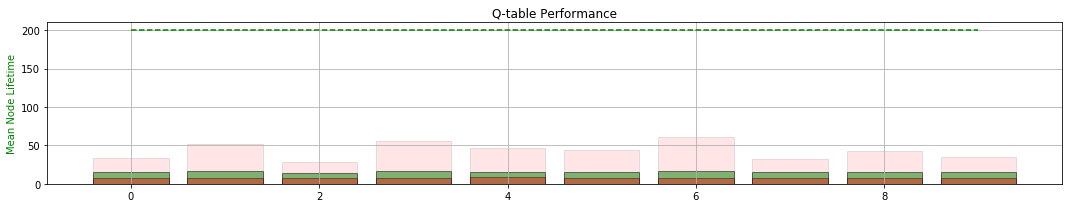

MEMORY COUNTER:  15558
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 608.245	LOSS : 613.938	LOSS : 622.859	LOSS : 604.660	LOSS : 574.089	LOSS : 562.010	LOSS : 564.108	LOSS : 547.562	
Validating... MEAN TIME:  17.12
LOSS : 547.390	LOSS : 537.459	LOSS : 535.182	LOSS : 525.628	LOSS : 516.639	LOSS : 521.940	LOSS : 522.217	LOSS : 517.969	
Validating... MEAN TIME:  9.435
LOSS : 529.036	LOSS : 519.280	LOSS : 521.855	LOSS : 522.867	LOSS : 516.176	LOSS : 515.513	LOSS : 512.977	LOSS : 513.032	
Validating... MEAN TIME:  9.29
LOSS : 503.594	LOSS : 511.776	LOSS : 509.487	LOSS : 504.128	LOSS : 502.555	LOSS : 497.721	LOSS : 505.367	LOSS : 504.897	
Validating... MEAN TIME:  11.635
LOSS : 501.229	LOSS : 498.485	LOSS : 495.246	LOSS : 494.100	LOSS : 488.475	LOSS : 490.367	LOSS : 488.598	LOSS : 491.298	
Validating... MEAN TIME:  28.61
TRAINING TIME:0:00:46.524395


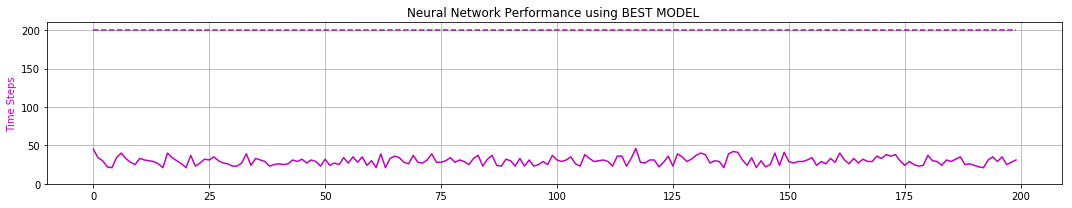

peak memory: 1342.14 MiB, increment: 1063.38 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   32786
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 135
TOTAL SERIAL TIMESTEPS:   48344
TOTAL PARALLEL TIME

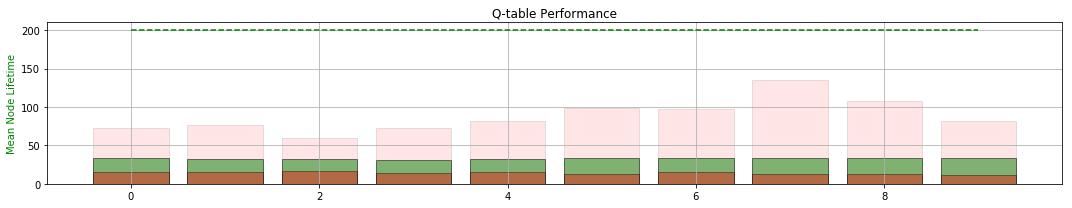

MEMORY COUNTER:  48344
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 362.874	LOSS : 371.481	LOSS : 364.518	LOSS : 362.694	LOSS : 361.485	LOSS : 339.718	LOSS : 352.391	LOSS : 351.161	
Validating... MEAN TIME:  79.755
LOSS : 354.321	LOSS : 357.985	LOSS : 350.595	LOSS : 353.668	LOSS : 351.272	LOSS : 364.053	LOSS : 339.986	LOSS : 350.942	
Validating... MEAN TIME:  72.025
LOSS : 350.972	LOSS : 352.989	LOSS : 339.560	LOSS : 346.221	LOSS : 357.143	LOSS : 347.880	LOSS : 351.247	LOSS : 345.322	
Validating... MEAN TIME:  67.915
LOSS : 347.004	LOSS : 343.389	LOSS : 350.102	LOSS : 348.352	LOSS : 346.204	LOSS : 361.253	LOSS : 350.898	LOSS : 350.221	
Validating... MEAN TIME:  70.77
LOSS : 346.489	LOSS : 347.109	LOSS : 349.023	LOSS : 345.152	LOSS : 334.224	LOSS : 350.636	LOSS : 344.796	LOSS : 342.400	
Validating... MEAN TIME:  76.89
TRAINING TIME:0:00:56.337733


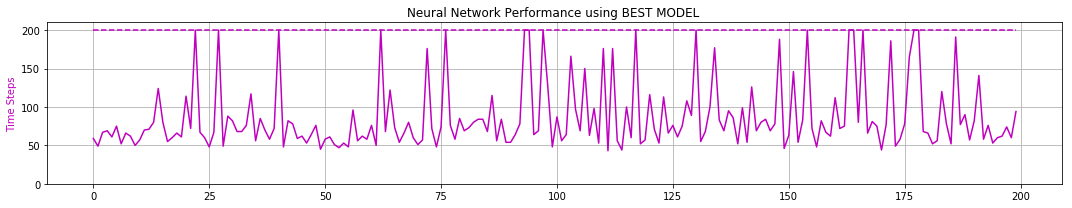

peak memory: 1366.00 MiB, increment: 1045.81 MiB
0 -max- [ 0.055  0.591  0.209  1.633]
0 -min- [-0.390 -1.026 -0.084 -0.704]

1 -max- [ 0.062  0.755  0.209  1.662]
1 -min- [-0.230 -1.016 -0.201 -1.048]

2 -max- [ 0.068  0.804  0.209  2.036]
2 -min- [-0.248 -1.201 -0.065 -0.888]

3 -max- [ 0.107  0.755  0.209  1.987]
3 -min- [-0.238 -1.413 -0.198 -0.990]

4 -max- [ 0.116  0.911  0.209  1.749]
4 -min- [-0.851 -1.542 -0.208 -1.194]

5 -max- [ 0.062  0.748  0.209  1.734]
5 -min- [-0.428 -1.122 -0.108 -0.953]

6 -max- [ 0.152  0.819  0.209  1.822]
6 -min- [-0.318 -1.011 -0.209 -1.288]

7 -max- [ 0.087  0.694  0.209  1.677]
7 -min- [-0.920 -1.006 -0.208 -0.898]

8 -max- [ 0.065  0.827  0.209  1.546]
8 -min- [-0.734 -1.019 -0.103 -1.106]

9 -max- [ 0.215  1.186  0.209  1.842]
9 -min- [-0.314 -1.159 -0.209 -1.679]

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   55964
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 137
TOTAL SERIAL TIMESTEPS:   104308
TOTAL PARALLEL TIM

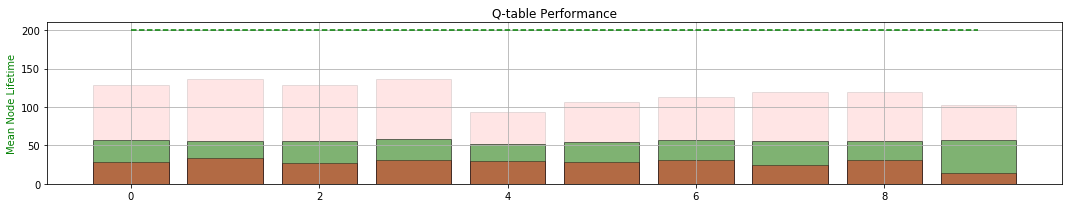

MEMORY COUNTER:  104308
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 255.924	LOSS : 259.750	LOSS : 250.782	LOSS : 252.535	LOSS : 251.220	LOSS : 259.201	LOSS : 256.966	LOSS : 258.953	
Validating... MEAN TIME:  87.99
LOSS : 254.691	LOSS : 261.139	LOSS : 249.516	LOSS : 251.203	LOSS : 255.536	LOSS : 248.479	LOSS : 258.257	LOSS : 240.418	
Validating... MEAN TIME:  106.175
LOSS : 249.078	LOSS : 248.925	LOSS : 244.453	LOSS : 242.459	LOSS : 251.049	LOSS : 249.316	LOSS : 249.591	LOSS : 248.182	
Validating... MEAN TIME:  114.83
LOSS : 246.782	LOSS : 248.533	LOSS : 248.009	LOSS : 253.054	LOSS : 246.028	LOSS : 240.794	LOSS : 240.288	LOSS : 244.107	
Validating... MEAN TIME:  127.405
LOSS : 250.180	LOSS : 242.243	LOSS : 241.260	LOSS : 243.562	LOSS : 252.986	LOSS : 251.911	LOSS : 254.839	LOSS : 257.718	
Validating... MEAN TIME:  129.23
TRAINING TIME:0:01:03.084291


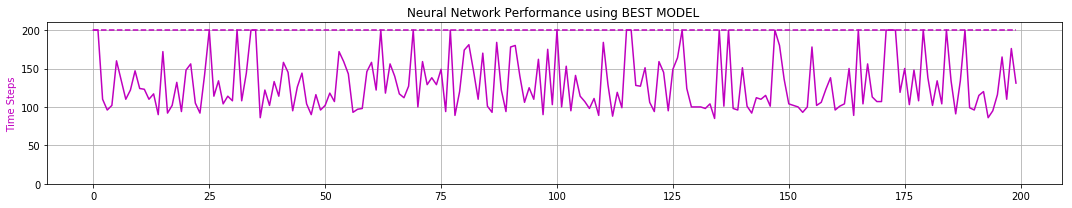

peak memory: 1396.62 MiB, increment: 1037.38 MiB
0 -max- [ 0.359  0.940  0.209  1.140]
0 -min- [-0.271 -0.940 -0.209 -1.478]

1 -max- [ 0.332  0.928  0.209  1.423]
1 -min- [-0.259 -0.965 -0.209 -1.483]

2 -max- [ 0.324  0.872  0.209  1.275]
2 -min- [-0.279 -0.957 -0.209 -1.431]

3 -max- [ 0.318  0.914  0.209  1.228]
3 -min- [-0.273 -1.149 -0.209 -1.303]

4 -max- [ 0.382  0.908  0.209  1.314]
4 -min- [-0.248 -0.963 -0.209 -1.496]

5 -max- [ 0.332  0.889  0.209  1.092]
5 -min- [-0.302 -0.957 -0.209 -1.428]

6 -max- [ 0.382  0.962  0.209  1.201]
6 -min- [-0.286 -0.957 -0.209 -1.184]

7 -max- [ 0.389  0.945  0.209  1.124]
7 -min- [-0.286 -0.962 -0.209 -1.479]

8 -max- [ 0.318  0.935  0.209  1.394]
8 -min- [-0.260 -0.953 -0.209 -1.357]

9 -max- [ 0.320  0.905  0.209  1.672]
9 -min- [-0.256 -1.130 -0.209 -1.353]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   84656
SMALLEST TIMESTEP: 54
LARGEST  TIMESTEP: 178
TOTAL SERIAL TIMESTEPS:   188964
TOTAL PARALLEL TIM

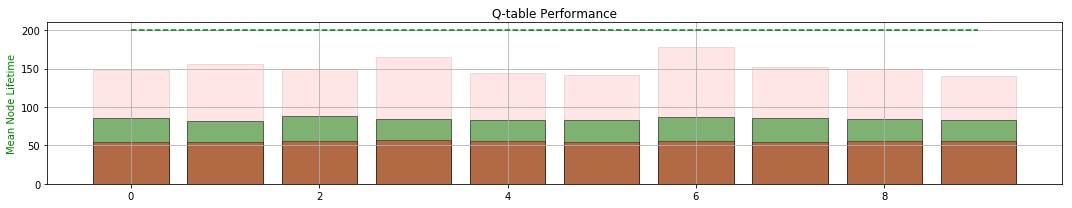

MEMORY COUNTER:  188964
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 187.278	LOSS : 192.604	LOSS : 191.518	LOSS : 186.159	LOSS : 183.693	LOSS : 185.323	LOSS : 199.130	LOSS : 186.234	
Validating... MEAN TIME:  137.615
LOSS : 188.588	LOSS : 190.021	LOSS : 179.774	LOSS : 190.550	LOSS : 180.242	LOSS : 184.057	LOSS : 184.667	LOSS : 192.895	
Validating... MEAN TIME:  143.135
LOSS : 180.177	LOSS : 180.368	LOSS : 198.651	LOSS : 186.338	LOSS : 181.739	LOSS : 187.525	LOSS : 192.494	LOSS : 192.918	
Validating... MEAN TIME:  137.72
LOSS : 189.526	LOSS : 181.932	LOSS : 188.670	LOSS : 184.383	LOSS : 183.783	LOSS : 182.939	LOSS : 185.617	LOSS : 177.280	
Validating... MEAN TIME:  138.625
LOSS : 181.769	LOSS : 183.232	LOSS : 191.404	LOSS : 186.483	LOSS : 177.302	LOSS : 185.664	LOSS : 189.220	LOSS : 185.199	
Validating... MEAN TIME:  141.29
TRAINING TIME:0:01:09.070272


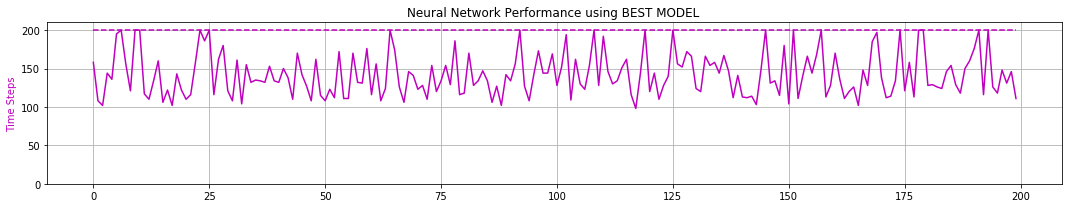

peak memory: 1403.54 MiB, increment: 979.04 MiB
0 -max- [ 0.162  0.432  0.050  0.667]
0 -min- [-0.695 -1.491 -0.209 -0.808]

1 -max- [ 0.191  0.539  0.047  0.650]
1 -min- [-0.681 -1.500 -0.209 -0.810]

2 -max- [ 0.186  0.605  0.048  0.577]
2 -min- [-0.702 -1.621 -0.209 -0.977]

3 -max- [ 0.189  0.583  0.048  0.589]
3 -min- [-0.752 -1.502 -0.209 -0.791]

4 -max- [ 0.187  0.626  0.046  0.685]
4 -min- [-0.717 -1.504 -0.209 -0.785]

5 -max- [ 0.191  0.443  0.048  0.618]
5 -min- [-0.676 -1.507 -0.209 -0.815]

6 -max- [ 0.192  0.575  0.049  0.716]
6 -min- [-0.814 -1.683 -0.209 -0.802]

7 -max- [ 0.179  0.530  0.049  0.676]
7 -min- [-0.713 -1.505 -0.209 -0.840]

8 -max- [ 0.182  0.439  0.049  0.667]
8 -min- [-0.731 -1.502 -0.209 -0.832]

9 -max- [ 0.193  0.436  0.050  0.618]
9 -min- [-0.706 -1.500 -0.209 -0.831]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   93046
SMALLEST TIMESTEP: 65
LARGEST  TIMESTEP: 178
TOTAL SERIAL TIMESTEPS:   282010
TOTAL PARALLEL TIME

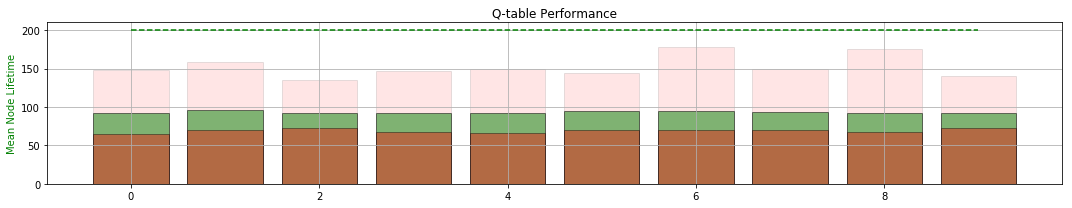

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 109.028	LOSS : 121.063	LOSS : 113.139	LOSS : 108.891	LOSS : 108.441	LOSS : 113.782	LOSS : 116.646	LOSS : 112.859	
Validating... MEAN TIME:  141.21
LOSS : 116.499	LOSS : 113.808	LOSS : 113.714	LOSS : 114.187	LOSS : 117.336	LOSS : 111.220	LOSS : 117.054	LOSS : 106.614	
Validating... MEAN TIME:  139.265
LOSS : 119.017	LOSS : 102.473	LOSS : 109.196	LOSS : 110.442	LOSS : 113.265	LOSS : 104.716	LOSS : 110.962	LOSS : 109.711	
Validating... MEAN TIME:  140.17
LOSS : 113.910	LOSS : 113.695	LOSS : 110.072	LOSS : 113.130	LOSS : 114.301	LOSS : 114.809	LOSS : 114.197	LOSS : 109.070	
Validating... MEAN TIME:  149.97
LOSS : 112.350	LOSS : 112.332	LOSS : 108.482	LOSS : 113.934	LOSS : 111.115	LOSS : 108.479	LOSS : 106.191	LOSS : 112.299	
Validating... MEAN TIME:  147.905
TRAINING TIME:0:01:09.482948


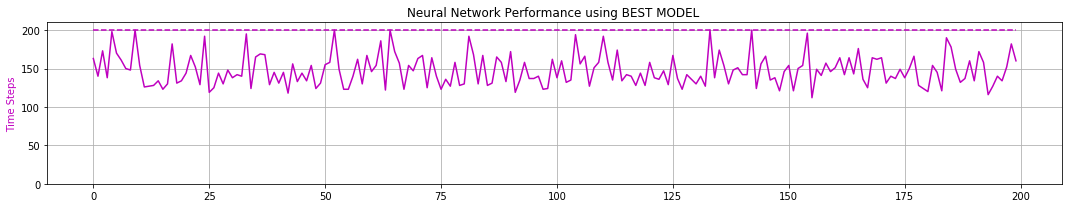

peak memory: 1404.29 MiB, increment: 978.91 MiB
0 -max- [ 0.165  0.436  0.047  0.652]
0 -min- [-1.203 -1.869 -0.209 -0.790]

1 -max- [ 0.187  0.633  0.048  0.663]
1 -min- [-1.209 -1.984 -0.209 -0.828]

2 -max- [ 0.149  0.439  0.048  0.612]
2 -min- [-1.331 -2.046 -0.209 -0.820]

3 -max- [ 0.170  0.443  0.046  0.857]
3 -min- [-1.239 -1.999 -0.209 -0.835]

4 -max- [ 0.187  0.536  0.048  0.521]
4 -min- [-1.163 -1.956 -0.209 -1.030]

5 -max- [ 0.180  0.446  0.049  0.682]
5 -min- [-1.246 -2.169 -0.209 -0.828]

6 -max- [ 0.204  0.610  0.049  0.761]
6 -min- [-1.184 -1.971 -0.209 -0.837]

7 -max- [ 0.178  0.610  0.049  0.644]
7 -min- [-1.256 -2.036 -0.209 -1.081]

8 -max- [ 0.152  0.437  0.050  0.618]
8 -min- [-1.177 -1.978 -0.209 -1.121]

9 -max- [ 0.193  0.439  0.048  0.539]
9 -min- [-1.130 -1.856 -0.209 -0.780]

Quantization TIME:  0.01 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   100081
SMALLEST TIMESTEP: 83
LARGEST  TIMESTEP: 159
TOTAL SERIAL TIMESTEPS:   382091
TOTAL PARALLEL TIM

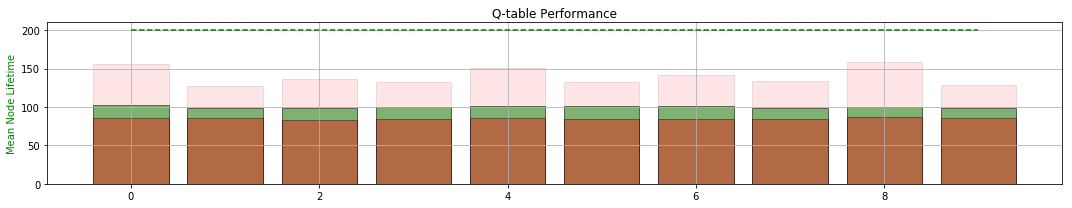

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 103.103	LOSS : 100.245	LOSS : 94.942	LOSS : 95.736	LOSS : 100.070	LOSS : 97.073	LOSS : 102.862	LOSS : 102.139	
Validating... MEAN TIME:  131.365
LOSS : 102.458	LOSS : 92.103	LOSS : 99.533	LOSS : 102.382	LOSS : 94.484	LOSS : 96.045	LOSS : 96.417	LOSS : 100.712	
Validating... MEAN TIME:  123.19
LOSS : 88.653	LOSS : 88.559	LOSS : 99.739	LOSS : 103.239	LOSS : 95.551	LOSS : 96.207	LOSS : 91.859	LOSS : 97.622	
Validating... MEAN TIME:  124.075
LOSS : 96.730	LOSS : 97.418	LOSS : 92.528	LOSS : 92.846	LOSS : 98.154	LOSS : 96.027	LOSS : 95.924	LOSS : 94.848	
Validating... MEAN TIME:  128.715
LOSS : 90.994	LOSS : 92.971	LOSS : 92.996	LOSS : 100.126	LOSS : 94.286	LOSS : 95.795	LOSS : 92.605	LOSS : 89.240	
Validating... MEAN TIME:  130.37
TRAINING TIME:0:01:06.619994


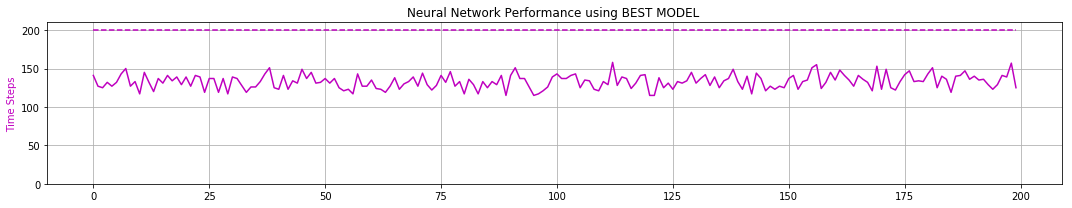

peak memory: 1484.62 MiB, increment: 978.78 MiB
0 -max- [ 0.200  0.618  0.048  0.668]
0 -min- [-1.729 -2.237 -0.209 -0.890]

1 -max- [ 0.147  0.552  0.048  0.637]
1 -min- [-1.650 -2.145 -0.209 -0.927]

2 -max- [ 0.163  0.599  0.046  0.645]
2 -min- [-1.715 -2.167 -0.209 -1.044]

3 -max- [ 0.158  0.634  0.048  0.645]
3 -min- [-1.674 -2.143 -0.209 -0.945]

4 -max- [ 0.174  0.604  0.049  0.799]
4 -min- [-1.651 -2.158 -0.209 -1.142]

5 -max- [ 0.136  0.604  0.049  0.645]
5 -min- [-1.728 -2.191 -0.209 -0.952]

6 -max- [ 0.173  0.554  0.049  0.669]
6 -min- [-1.732 -2.156 -0.209 -0.939]

7 -max- [ 0.156  0.635  0.050  0.678]
7 -min- [-1.649 -2.173 -0.209 -1.170]

8 -max- [ 0.223  0.634  0.048  0.617]
8 -min- [-1.726 -2.152 -0.209 -0.911]

9 -max- [ 0.131  0.624  0.048  0.668]
9 -min- [-1.601 -2.053 -0.209 -1.068]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   99398
SMALLEST TIMESTEP: 26
LARGEST  TIMESTEP: 122
TOTAL SERIAL TIMESTEPS:   481489
TOTAL PARALLEL TIME

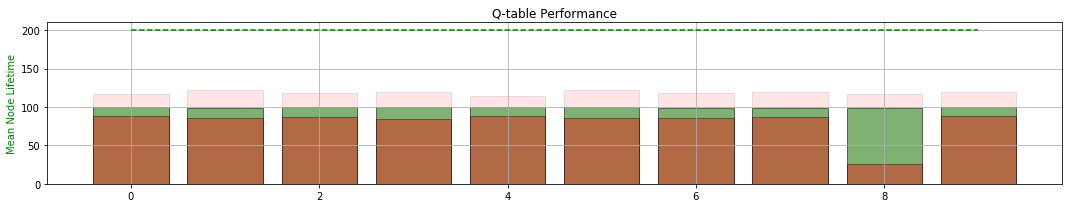

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 95.212	LOSS : 88.560	LOSS : 92.523	LOSS : 93.864	LOSS : 88.900	LOSS : 92.392	LOSS : 85.298	LOSS : 96.133	
Validating... MEAN TIME:  127.04
LOSS : 85.844	LOSS : 88.763	LOSS : 90.096	LOSS : 86.278	LOSS : 88.183	LOSS : 92.767	LOSS : 88.354	LOSS : 91.553	
Validating... MEAN TIME:  131.13
LOSS : 90.743	LOSS : 89.608	LOSS : 95.510	LOSS : 89.737	LOSS : 90.546	LOSS : 90.848	LOSS : 86.417	LOSS : 91.860	
Validating... MEAN TIME:  137.225
LOSS : 92.312	LOSS : 90.552	LOSS : 84.507	LOSS : 91.219	LOSS : 95.092	LOSS : 89.224	LOSS : 92.850	LOSS : 88.123	
Validating... MEAN TIME:  144.72
LOSS : 93.570	LOSS : 90.179	LOSS : 93.023	LOSS : 90.908	LOSS : 93.995	LOSS : 93.871	LOSS : 92.813	LOSS : 83.231	
Validating... MEAN TIME:  157.515
TRAINING TIME:0:01:08.222827


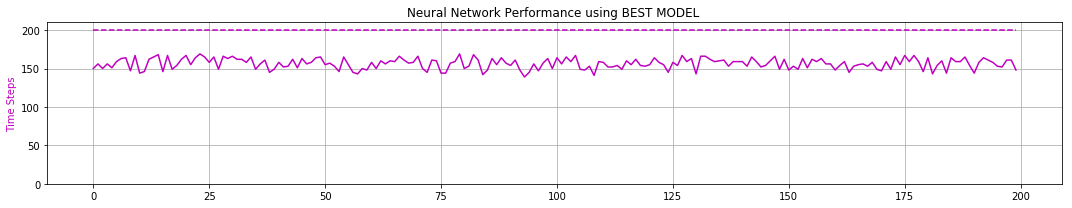

peak memory: 1437.57 MiB, increment: 991.18 MiB
0 -max- [ 0.148  0.634  0.048  0.784]
0 -min- [-1.968 -2.409 -0.209 -1.010]

1 -max- [ 0.160  0.632  0.046  0.662]
1 -min- [-2.042 -2.405 -0.209 -0.938]

2 -max- [ 0.148  0.624  0.048  0.644]
2 -min- [-2.041 -2.591 -0.209 -1.065]

3 -max- [ 0.150  0.578  0.049  0.635]
3 -min- [-2.044 -2.412 -0.209 -0.809]

4 -max- [ 0.148  0.608  0.049  0.850]
4 -min- [-1.980 -2.512 -0.209 -1.035]

5 -max- [ 0.167  0.635  0.049  0.666]
5 -min- [-1.973 -2.380 -0.209 -0.994]

6 -max- [ 0.159  0.802  0.052  0.647]
6 -min- [-2.009 -2.403 -0.209 -1.108]

7 -max- [ 0.184  0.448  0.048  0.624]
7 -min- [-2.013 -2.377 -0.209 -1.014]

8 -max- [ 0.143  0.745  0.054  0.634]
8 -min- [-2.062 -2.412 -0.209 -1.219]

9 -max- [ 0.166  0.631  0.051  0.675]
9 -min- [-2.007 -2.387 -0.209 -1.117]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   64422
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 123
TOTAL SERIAL TIMESTEPS:   545911
TOTAL PARALLEL TIME

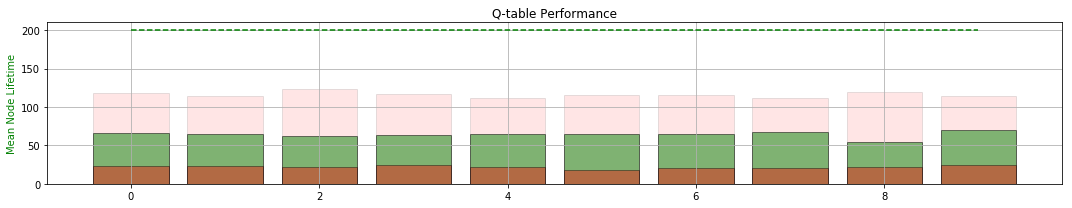

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 113.881	LOSS : 113.801	LOSS : 107.440	LOSS : 106.729	LOSS : 108.846	LOSS : 114.124	LOSS : 107.072	LOSS : 111.495	
Validating... MEAN TIME:  144.375
LOSS : 106.060	LOSS : 110.147	LOSS : 109.312	LOSS : 104.120	LOSS : 113.625	LOSS : 108.732	LOSS : 108.382	LOSS : 115.464	
Validating... MEAN TIME:  83.675
LOSS : 108.288	LOSS : 109.568	LOSS : 112.681	LOSS : 112.779	LOSS : 106.578	LOSS : 108.670	LOSS : 112.277	LOSS : 107.076	
Validating... MEAN TIME:  32.43
LOSS : 99.529	LOSS : 107.145	LOSS : 103.894	LOSS : 107.188	LOSS : 104.565	LOSS : 99.541	LOSS : 103.552	LOSS : 104.652	
Validating... MEAN TIME:  39.215
LOSS : 107.327	LOSS : 111.723	LOSS : 110.451	LOSS : 106.446	LOSS : 110.431	LOSS : 103.761	LOSS : 113.318	LOSS : 104.897	
Validating... MEAN TIME:  172.115
TRAINING TIME:0:00:59.943856


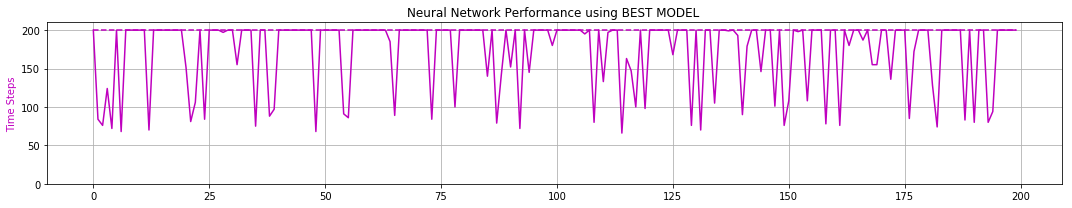

peak memory: 1438.24 MiB, increment: 995.75 MiB
0 -max- [ 0.195  0.619  0.046  0.882]
0 -min- [-2.400 -2.353 -0.209 -1.111]

1 -max- [ 0.188  0.623  0.048  0.812]
1 -min- [-2.400 -2.260 -0.209 -1.076]

2 -max- [ 0.202  0.640  0.049  0.912]
2 -min- [-2.399 -2.256 -0.209 -1.118]

3 -max- [ 0.177  0.633  0.049  0.923]
3 -min- [-2.398 -2.400 -0.209 -1.108]

4 -max- [ 0.201  0.616  0.049  0.763]
4 -min- [-2.400 -2.261 -0.209 -0.991]

5 -max- [ 0.191  0.590  0.056  0.940]
5 -min- [-2.400 -2.417 -0.209 -1.044]

6 -max- [ 0.209  0.633  0.048  0.908]
6 -min- [-2.399 -2.369 -0.209 -1.075]

7 -max- [ 0.178  0.603  0.049  0.781]
7 -min- [-2.400 -2.243 -0.209 -1.109]

8 -max- [ 0.205  0.631  0.051  0.845]
8 -min- [-2.400 -2.255 -0.209 -1.005]

9 -max- [ 0.169  0.631  0.049  0.901]
9 -min- [-2.399 -2.415 -0.209 -1.061]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   109704
SMALLEST TIMESTEP: 84
LARGEST  TIMESTEP: 182
TOTAL SERIAL TIMESTEPS:   655615
TOTAL PARALLEL TIM

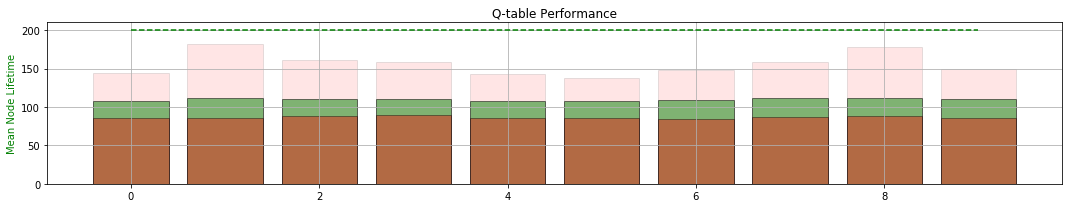

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 102.475	LOSS : 114.282	LOSS : 110.858	LOSS : 106.978	LOSS : 105.011	LOSS : 113.514	LOSS : 105.384	LOSS : 106.857	
Validating... MEAN TIME:  124.47
LOSS : 108.379	LOSS : 109.433	LOSS : 110.672	LOSS : 110.957	LOSS : 103.469	LOSS : 101.843	LOSS : 103.969	LOSS : 104.806	
Validating... MEAN TIME:  128.275
LOSS : 110.770	LOSS : 109.751	LOSS : 109.667	LOSS : 104.425	LOSS : 104.456	LOSS : 101.250	LOSS : 104.893	LOSS : 109.584	
Validating... MEAN TIME:  132.51
LOSS : 108.699	LOSS : 108.464	LOSS : 109.706	LOSS : 104.968	LOSS : 111.805	LOSS : 100.917	LOSS : 105.243	LOSS : 105.194	
Validating... MEAN TIME:  134.38
LOSS : 106.428	LOSS : 100.509	LOSS : 106.324	LOSS : 110.707	LOSS : 113.409	LOSS : 109.746	LOSS : 106.426	LOSS : 109.730	
Validating... MEAN TIME:  135.17
TRAINING TIME:0:01:07.178759


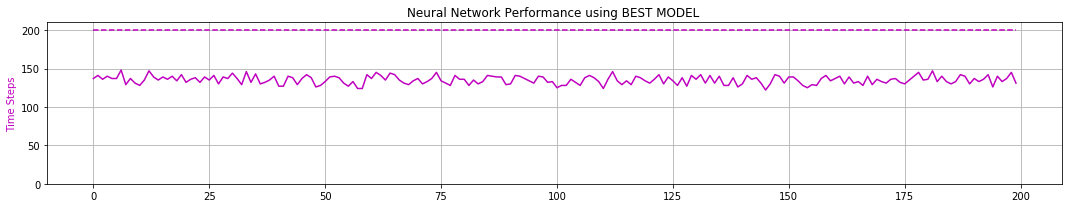

peak memory: 1479.62 MiB, increment: 978.40 MiB
0 -max- [ 0.209  0.584  0.209  1.100]
0 -min- [-1.578 -1.873 -0.160 -0.764]

1 -max- [ 0.223  0.624  0.209  1.366]
1 -min- [-1.597 -2.083 -0.171 -0.775]

2 -max- [ 0.196  0.612  0.209  1.074]
2 -min- [-1.642 -1.872 -0.176 -0.794]

3 -max- [ 0.242  0.541  0.209  1.036]
3 -min- [-1.593 -1.875 -0.159 -0.784]

4 -max- [ 0.217  0.620  0.209  1.249]
4 -min- [-1.652 -2.033 -0.190 -0.884]

5 -max- [ 0.259  0.629  0.209  1.091]
5 -min- [-1.590 -1.854 -0.175 -0.833]

6 -max- [ 0.192  0.592  0.209  1.108]
6 -min- [-1.634 -1.885 -0.182 -0.914]

7 -max- [ 0.226  0.434  0.209  1.011]
7 -min- [-1.582 -1.881 -0.176 -0.783]

8 -max- [ 0.198  0.433  0.209  1.076]
8 -min- [-1.697 -2.019 -0.163 -0.768]

9 -max- [ 0.198  0.556  0.209  1.103]
9 -min- [-1.574 -1.874 -0.162 -0.763]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   99754
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 116
TOTAL SERIAL TIMESTEPS:   755369
TOTAL PARALLEL TIME

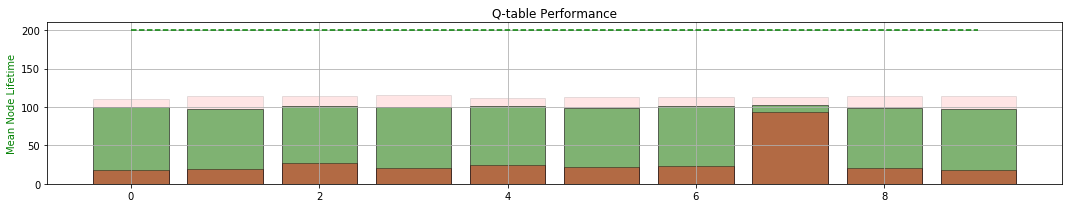

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 95.818	LOSS : 101.038	LOSS : 97.223	LOSS : 96.288	LOSS : 90.469	LOSS : 97.894	LOSS : 95.263	LOSS : 95.822	
Validating... MEAN TIME:  126.32
LOSS : 92.091	LOSS : 89.238	LOSS : 96.745	LOSS : 93.212	LOSS : 93.374	LOSS : 94.546	LOSS : 88.737	LOSS : 94.866	
Validating... MEAN TIME:  121.11
LOSS : 90.721	LOSS : 89.275	LOSS : 92.976	LOSS : 92.907	LOSS : 89.813	LOSS : 88.987	LOSS : 94.545	LOSS : 97.115	
Validating... MEAN TIME:  122.25
LOSS : 88.413	LOSS : 88.100	LOSS : 88.495	LOSS : 88.922	LOSS : 92.070	LOSS : 94.897	LOSS : 87.034	LOSS : 92.232	
Validating... MEAN TIME:  124.02
LOSS : 92.438	LOSS : 89.778	LOSS : 92.820	LOSS : 90.566	LOSS : 88.309	LOSS : 92.570	LOSS : 88.089	LOSS : 94.001	
Validating... MEAN TIME:  123.485
TRAINING TIME:0:01:06.157861


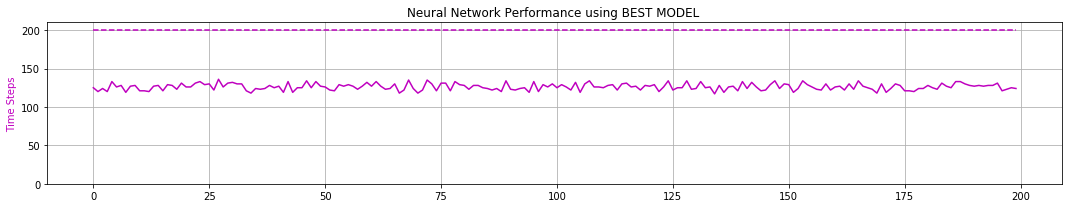

peak memory: 1484.89 MiB, increment: 1072.38 MiB
0 -max- [ 0.182  0.824  0.093  1.233]
0 -min- [-2.400 -2.823 -0.209 -1.191]

1 -max- [ 0.178  0.787  0.049  0.828]
1 -min- [-2.400 -2.571 -0.208 -1.190]

2 -max- [ 0.201  0.827  0.053  0.841]
2 -min- [-2.399 -2.536 -0.209 -1.219]

3 -max- [ 0.195  0.827  0.050  0.970]
3 -min- [-2.400 -2.589 -0.209 -1.202]

4 -max- [ 0.205  0.804  0.048  0.719]
4 -min- [-2.398 -2.577 -0.208 -1.205]

5 -max- [ 0.169  0.785  0.048  0.903]
5 -min- [-2.400 -2.625 -0.209 -1.287]

6 -max- [ 0.198  1.018  0.051  0.814]
6 -min- [-2.400 -2.634 -0.208 -1.527]

7 -max- [ 0.174  0.788  0.049  0.923]
7 -min- [-2.399 -2.600 -0.208 -1.246]

8 -max- [ 0.201  0.636  0.050  0.715]
8 -min- [-2.400 -2.565 -0.209 -1.101]

9 -max- [ 0.193  0.805  0.050  0.781]
9 -min- [-2.400 -2.436 -0.209 -1.228]

Quantization TIME:  0.01 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   60731
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 109
TOTAL SERIAL TIMESTEPS:   816100
TOTAL PARALLEL TI

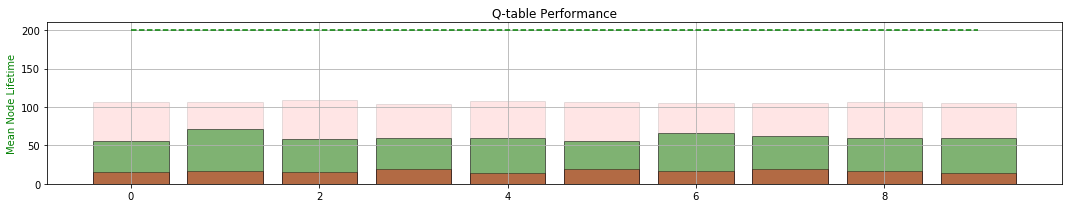

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 110.637	LOSS : 113.868	LOSS : 108.627	LOSS : 107.123	LOSS : 114.751	LOSS : 110.526	LOSS : 103.007	LOSS : 109.351	
Validating... MEAN TIME:  123.31
LOSS : 108.684	LOSS : 103.439	LOSS : 105.389	LOSS : 107.943	LOSS : 109.091	LOSS : 111.456	LOSS : 109.093	LOSS : 111.178	
Validating... MEAN TIME:  121.78
LOSS : 107.799	LOSS : 110.244	LOSS : 110.698	LOSS : 99.794	LOSS : 104.592	LOSS : 106.506	LOSS : 110.188	LOSS : 108.425	
Validating... MEAN TIME:  122.395
LOSS : 102.735	LOSS : 105.776	LOSS : 106.118	LOSS : 105.563	LOSS : 106.207	LOSS : 113.590	LOSS : 106.354	LOSS : 103.723	
Validating... MEAN TIME:  120.34
LOSS : 105.684	LOSS : 100.355	LOSS : 109.858	LOSS : 103.464	LOSS : 106.075	LOSS : 108.659	LOSS : 108.326	LOSS : 108.158	
Validating... MEAN TIME:  120.81
TRAINING TIME:0:01:06.498537


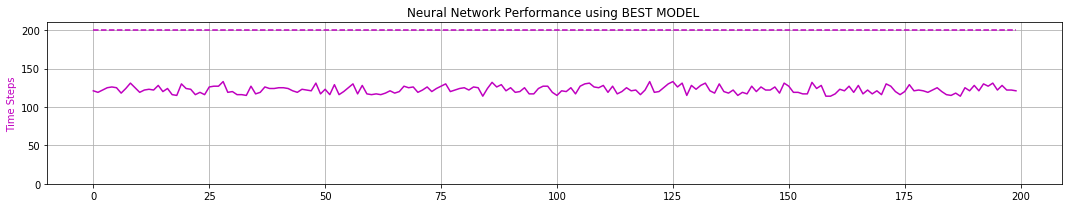

peak memory: 1447.76 MiB, increment: 978.15 MiB
0 -max- [ 0.189  0.799  0.085  0.930]
0 -min- [-2.398 -2.557 -0.209 -1.168]

1 -max- [ 0.213  0.998  0.080  0.852]
1 -min- [-2.399 -2.550 -0.209 -1.361]

2 -max- [ 0.189  1.019  0.089  0.932]
2 -min- [-2.400 -2.550 -0.209 -1.382]

3 -max- [ 0.209  1.019  0.078  0.793]
3 -min- [-2.399 -2.551 -0.209 -1.363]

4 -max- [ 0.184  0.982  0.079  0.933]
4 -min- [-2.400 -2.615 -0.209 -1.503]

5 -max- [ 0.212  0.930  0.095  0.954]
5 -min- [-2.399 -2.630 -0.209 -1.363]

6 -max- [ 0.189  0.786  0.099  0.894]
6 -min- [-2.399 -2.576 -0.209 -1.174]

7 -max- [ 0.197  0.762  0.076  0.938]
7 -min- [-2.400 -2.550 -0.209 -1.216]

8 -max- [ 0.201  0.830  0.076  0.940]
8 -min- [-2.400 -2.606 -0.209 -1.320]

9 -max- [ 0.187  0.832  0.080  0.945]
9 -min- [-2.400 -2.597 -0.209 -1.303]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   93332
SMALLEST TIMESTEP: 16
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   909432
TOTAL PARALLEL TIM

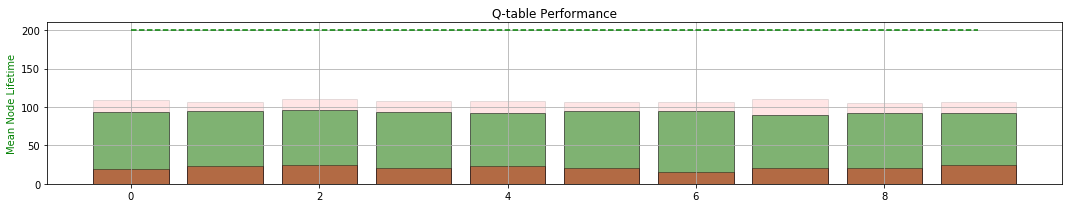

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 116.050	LOSS : 113.658	LOSS : 111.892	LOSS : 113.479	LOSS : 109.702	LOSS : 107.941	LOSS : 108.116	LOSS : 114.935	
Validating... MEAN TIME:  108.65
LOSS : 115.896	LOSS : 115.721	LOSS : 107.693	LOSS : 117.419	LOSS : 112.171	LOSS : 112.054	LOSS : 110.161	LOSS : 111.125	
Validating... MEAN TIME:  108.845
LOSS : 115.118	LOSS : 106.435	LOSS : 105.692	LOSS : 113.289	LOSS : 107.221	LOSS : 109.788	LOSS : 114.041	LOSS : 104.698	
Validating... MEAN TIME:  112.205
LOSS : 106.021	LOSS : 107.216	LOSS : 108.527	LOSS : 117.416	LOSS : 106.153	LOSS : 110.679	LOSS : 108.079	LOSS : 108.555	
Validating... MEAN TIME:  113.08
LOSS : 111.834	LOSS : 113.663	LOSS : 112.637	LOSS : 118.094	LOSS : 108.402	LOSS : 106.421	LOSS : 105.113	LOSS : 109.424	
Validating... MEAN TIME:  113.83
TRAINING TIME:0:01:04.857064


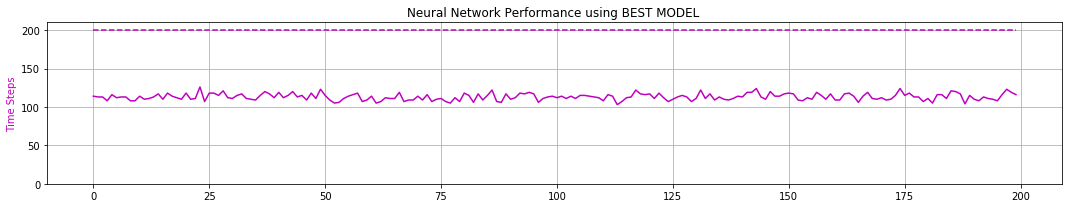

peak memory: 1430.32 MiB, increment: 1036.28 MiB
0 -max- [ 0.194  0.783  0.049  1.010]
0 -min- [-2.400 -2.911 -0.209 -1.206]

1 -max- [ 0.189  0.827  0.054  0.916]
1 -min- [-2.399 -2.767 -0.209 -1.173]

2 -max- [ 0.205  0.636  0.048  0.747]
2 -min- [-2.400 -2.746 -0.208 -0.962]

3 -max- [ 0.177  0.820  0.048  1.095]
3 -min- [-2.400 -2.912 -0.208 -1.249]

4 -max- [ 0.196  0.735  0.055  0.756]
4 -min- [-2.400 -2.750 -0.209 -1.121]

5 -max- [ 0.174  0.822  0.070  1.021]
5 -min- [-2.399 -2.927 -0.209 -1.177]

6 -max- [ 0.187  0.635  0.053  0.913]
6 -min- [-2.400 -2.740 -0.209 -1.008]

7 -max- [ 0.193  0.828  0.060  1.006]
7 -min- [-2.400 -2.910 -0.208 -1.215]

8 -max- [ 0.179  0.804  0.060  0.936]
8 -min- [-2.400 -2.742 -0.209 -1.178]

9 -max- [ 0.163  0.826  0.050  0.986]
9 -min- [-2.400 -2.926 -0.208 -1.258]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   99802
SMALLEST TIMESTEP: 20
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   1009234
TOTAL PARALLEL T

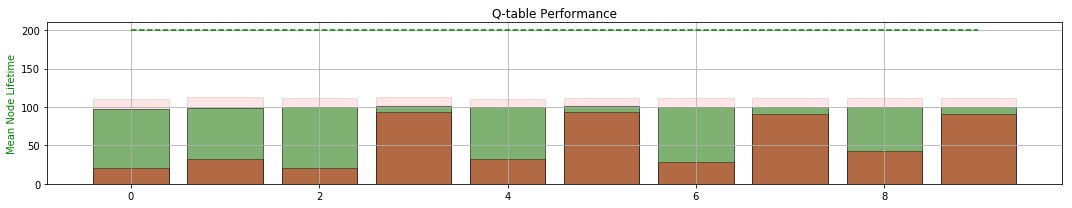

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 93.736	LOSS : 93.356	LOSS : 95.962	LOSS : 93.069	LOSS : 91.624	LOSS : 92.804	LOSS : 95.973	LOSS : 95.816	
Validating... MEAN TIME:  103.025
LOSS : 89.382	LOSS : 90.158	LOSS : 91.038	LOSS : 94.433	LOSS : 89.058	LOSS : 90.878	LOSS : 92.978	LOSS : 93.082	
Validating... MEAN TIME:  103.875
LOSS : 87.262	LOSS : 97.358	LOSS : 96.334	LOSS : 93.754	LOSS : 92.705	LOSS : 92.602	LOSS : 89.032	LOSS : 93.017	
Validating... MEAN TIME:  104.25
LOSS : 92.161	LOSS : 92.250	LOSS : 89.081	LOSS : 90.578	LOSS : 92.579	LOSS : 93.448	LOSS : 87.407	LOSS : 95.012	
Validating... MEAN TIME:  104.75
LOSS : 89.952	LOSS : 90.848	LOSS : 87.690	LOSS : 92.746	LOSS : 90.844	LOSS : 92.544	LOSS : 91.429	LOSS : 91.001	
Validating... MEAN TIME:  104.15
TRAINING TIME:0:01:03.841445


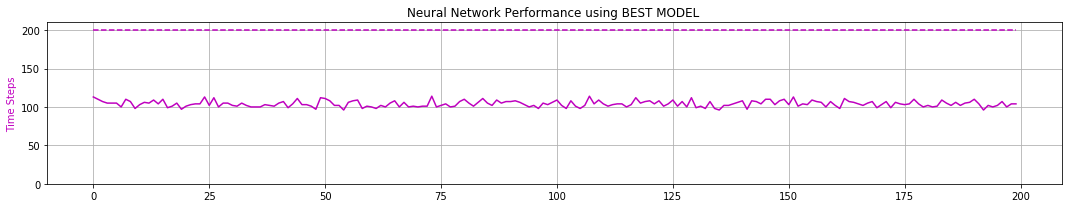

peak memory: 1447.21 MiB, increment: 1016.96 MiB
0 -max- [ 0.174  0.820  0.052  0.918]
0 -min- [-2.400 -2.987 -0.207 -1.250]

1 -max- [ 0.183  0.830  0.048  0.933]
1 -min- [-2.399 -2.991 -0.209 -1.130]

2 -max- [ 0.161  0.633  0.048  0.935]
2 -min- [-2.398 -2.990 -0.207 -1.059]

3 -max- [ 0.180  0.778  0.051  0.725]
3 -min- [-2.399 -2.954 -0.206 -1.121]

4 -max- [ 0.158  0.785  0.049  0.886]
4 -min- [-2.399 -2.988 -0.207 -1.165]

5 -max- [ 0.167  0.817  0.050  0.730]
5 -min- [-2.400 -2.974 -0.204 -1.196]

6 -max- [ 0.172  0.769  0.050  0.817]
6 -min- [-2.399 -2.984 -0.209 -1.117]

7 -max- [ 0.158  0.747  0.049  0.870]
7 -min- [-2.400 -3.092 -0.205 -1.225]

8 -max- [ 0.153  0.817  0.050  0.996]
8 -min- [-2.400 -3.181 -0.203 -1.242]

9 -max- [ 0.157  0.801  0.050  0.736]
9 -min- [-2.400 -2.968 -0.198 -1.228]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   89770
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   1099004
TOTAL PARALLEL T

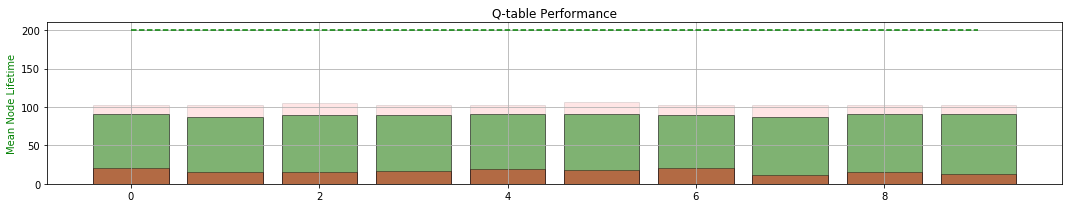

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 92.201	LOSS : 90.904	LOSS : 89.882	LOSS : 92.255	LOSS : 91.072	LOSS : 92.751	LOSS : 92.950	LOSS : 90.327	
Validating... MEAN TIME:  98.175
LOSS : 91.740	LOSS : 90.516	LOSS : 85.379	LOSS : 91.527	LOSS : 90.271	LOSS : 96.332	LOSS : 91.045	LOSS : 90.227	
Validating... MEAN TIME:  100.485
LOSS : 89.089	LOSS : 90.123	LOSS : 88.892	LOSS : 90.485	LOSS : 90.871	LOSS : 91.473	LOSS : 86.823	LOSS : 87.596	
Validating... MEAN TIME:  101.96
LOSS : 91.708	LOSS : 92.329	LOSS : 90.237	LOSS : 86.576	LOSS : 85.861	LOSS : 91.989	LOSS : 90.127	LOSS : 92.477	
Validating... MEAN TIME:  102.27
LOSS : 90.863	LOSS : 92.673	LOSS : 93.188	LOSS : 87.374	LOSS : 90.823	LOSS : 88.772	LOSS : 91.845	LOSS : 89.765	
Validating... MEAN TIME:  102.765
TRAINING TIME:0:01:01.823834


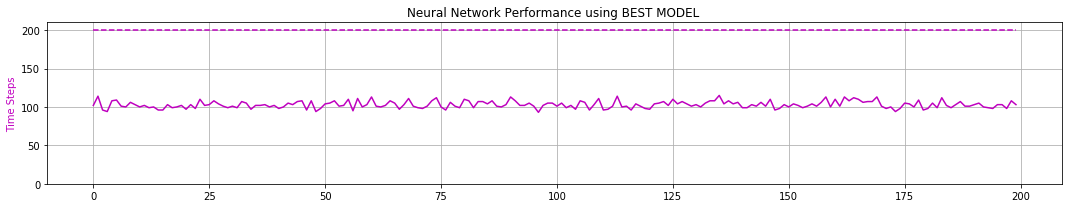

peak memory: 1470.09 MiB, increment: 1036.37 MiB
0 -max- [ 0.203  1.214  0.048  0.655]
0 -min- [-2.399 -2.975 -0.209 -1.657]

1 -max- [ 0.179  1.139  0.048  0.663]
1 -min- [-2.399 -3.114 -0.209 -1.643]

2 -max- [ 0.198  1.214  0.051  0.673]
2 -min- [-2.400 -3.345 -0.209 -1.657]

3 -max- [ 0.176  0.934  0.049  0.655]
3 -min- [-2.398 -3.084 -0.209 -1.381]

4 -max- [ 0.183  0.964  0.050  0.608]
4 -min- [-2.399 -3.103 -0.209 -1.458]

5 -max- [ 0.195  0.827  0.050  0.758]
5 -min- [-2.400 -3.077 -0.209 -1.285]

6 -max- [ 0.189  0.975  0.049  0.694]
6 -min- [-2.400 -3.072 -0.209 -1.380]

7 -max- [ 0.171  0.967  0.050  0.774]
7 -min- [-2.400 -3.339 -0.209 -1.372]

8 -max- [ 0.185  1.016  0.050  0.671]
8 -min- [-2.399 -3.107 -0.209 -1.411]

9 -max- [ 0.170  1.178  0.050  0.637]
9 -min- [-2.397 -2.977 -0.209 -1.667]

Quantization TIME:  0.01 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   91707
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   1190711
TOTAL PARALLEL T

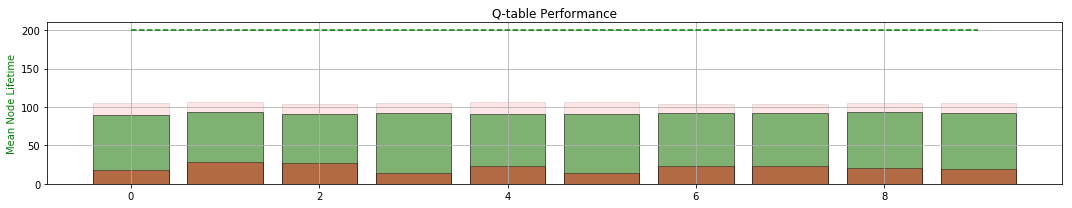

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 95.679	LOSS : 90.885	LOSS : 90.081	LOSS : 92.955	LOSS : 96.349	LOSS : 91.209	LOSS : 95.312	LOSS : 92.047	
Validating... MEAN TIME:  98.96
LOSS : 87.351	LOSS : 89.130	LOSS : 89.243	LOSS : 90.797	LOSS : 95.738	LOSS : 91.563	LOSS : 89.824	LOSS : 93.571	
Validating... MEAN TIME:  101.055
LOSS : 94.490	LOSS : 84.042	LOSS : 92.193	LOSS : 90.544	LOSS : 90.738	LOSS : 89.369	LOSS : 90.471	LOSS : 92.081	
Validating... MEAN TIME:  102.075
LOSS : 90.703	LOSS : 91.919	LOSS : 91.521	LOSS : 90.552	LOSS : 90.897	LOSS : 94.977	LOSS : 96.542	LOSS : 90.050	
Validating... MEAN TIME:  103.285
LOSS : 83.230	LOSS : 92.672	LOSS : 92.794	LOSS : 92.942	LOSS : 90.108	LOSS : 90.906	LOSS : 92.932	LOSS : 90.641	
Validating... MEAN TIME:  104.94
TRAINING TIME:0:01:01.775890


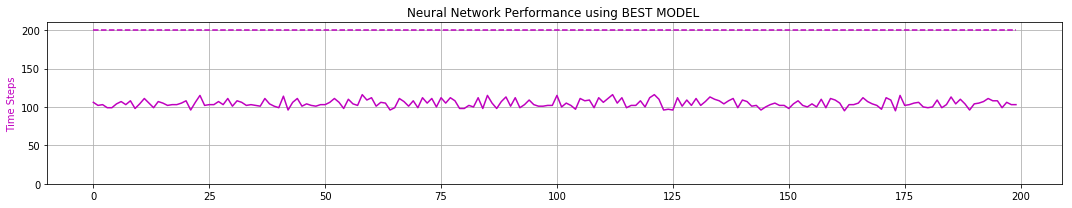

peak memory: 1470.09 MiB, increment: 977.65 MiB
0 -max- [ 0.192  0.948  0.048  0.753]
0 -min- [-2.400 -3.287 -0.209 -1.375]

1 -max- [ 0.190  0.930  0.051  0.610]
1 -min- [-2.398 -3.280 -0.209 -1.374]

2 -max- [ 0.179  1.006  0.049  0.736]
2 -min- [-2.400 -3.323 -0.209 -1.480]

3 -max- [ 0.170  0.951  0.050  0.809]
3 -min- [-2.399 -3.341 -0.209 -1.378]

4 -max- [ 0.188  0.934  0.056  0.682]
4 -min- [-2.399 -3.325 -0.208 -1.417]

5 -max- [ 0.168  0.829  0.049  0.670]
5 -min- [-2.400 -3.273 -0.209 -1.305]

6 -max- [ 0.163  0.967  0.050  0.677]
6 -min- [-2.398 -3.321 -0.209 -1.372]

7 -max- [ 0.172  0.830  0.050  0.605]
7 -min- [-2.399 -3.307 -0.209 -1.238]

8 -max- [ 0.168  0.989  0.050  0.641]
8 -min- [-2.400 -3.321 -0.209 -1.415]

9 -max- [ 0.179  1.011  0.048  0.664]
9 -min- [-2.400 -3.304 -0.209 -1.374]

Quantization TIME:  0.02 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   77232
SMALLEST TIMESTEP: 30
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   1267943
TOTAL PARALLEL TI

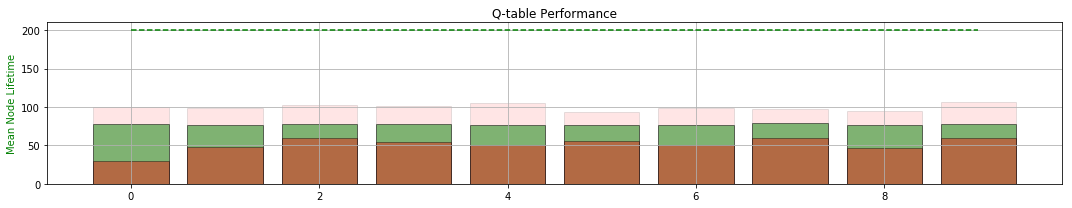

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 100.299	LOSS : 104.825	LOSS : 104.582	LOSS : 108.634	LOSS : 104.328	LOSS : 103.517	LOSS : 101.195	LOSS : 101.734	
Validating... MEAN TIME:  133.685
LOSS : 101.216	LOSS : 105.552	LOSS : 109.528	LOSS : 98.377	LOSS : 101.504	LOSS : 109.737	LOSS : 107.273	LOSS : 100.577	
Validating... MEAN TIME:  163.365
LOSS : 103.147	LOSS : 97.952	LOSS : 100.069	LOSS : 102.307	LOSS : 97.692	LOSS : 102.924	LOSS : 103.740	LOSS : 101.343	
Validating... MEAN TIME:  171.005
LOSS : 111.531	LOSS : 104.387	LOSS : 105.630	LOSS : 103.897	LOSS : 102.151	LOSS : 102.380	LOSS : 105.685	LOSS : 105.185	
Validating... MEAN TIME:  183.735
LOSS : 100.671	LOSS : 99.956	LOSS : 102.405	LOSS : 99.363	LOSS : 104.391	LOSS : 104.809	LOSS : 101.354	LOSS : 107.230	
Validating... MEAN TIME:  185.37
TRAINING TIME:0:01:13.431965


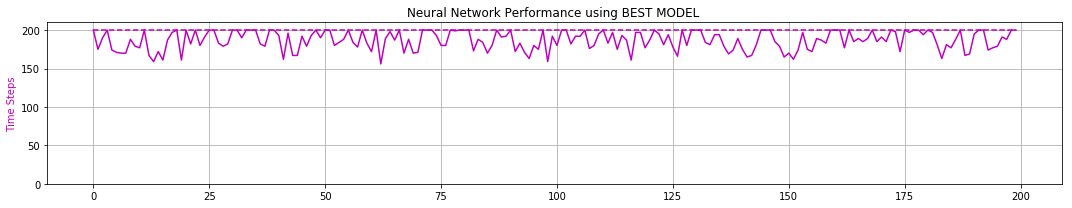

peak memory: 1489.62 MiB, increment: 977.52 MiB
0 -max- [ 0.174  0.930  0.051  0.754]
0 -min- [-2.099 -2.938 -0.209 -1.363]

1 -max- [ 0.144  0.800  0.049  0.667]
1 -min- [-2.121 -2.957 -0.209 -1.218]

2 -max- [ 0.152  0.823  0.050  0.780]
2 -min- [-2.357 -3.126 -0.209 -1.257]

3 -max- [ 0.172  0.771  0.050  0.692]
3 -min- [-2.398 -3.306 -0.209 -1.227]

4 -max- [ 0.152  0.766  0.049  0.762]
4 -min- [-2.397 -3.317 -0.209 -1.114]

5 -max- [ 0.150  0.824  0.050  0.696]
5 -min- [-1.953 -2.697 -0.209 -1.206]

6 -max- [ 0.154  0.809  0.050  0.690]
6 -min- [-2.400 -3.311 -0.209 -1.196]

7 -max- [ 0.146  0.934  0.050  0.645]
7 -min- [-2.377 -3.295 -0.209 -1.363]

8 -max- [ 0.160  0.830  0.048  0.661]
8 -min- [-1.812 -2.757 -0.209 -1.240]

9 -max- [ 0.165  0.757  0.050  0.702]
9 -min- [-2.368 -3.144 -0.209 -1.231]

Quantization TIME:  0.02 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   155479
SMALLEST TIMESTEP: 130
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1423422
TOTAL PARALLEL 

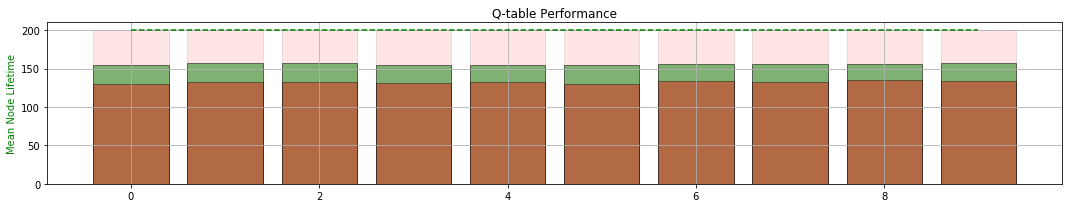

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 71.381	LOSS : 69.849	LOSS : 78.142	LOSS : 75.012	LOSS : 77.401	LOSS : 74.064	LOSS : 70.849	LOSS : 69.621	
Validating... MEAN TIME:  136.065
LOSS : 67.876	LOSS : 78.644	LOSS : 69.220	LOSS : 73.722	LOSS : 70.885	LOSS : 68.557	LOSS : 70.415	LOSS : 69.653	
Validating... MEAN TIME:  138.585
LOSS : 68.065	LOSS : 76.384	LOSS : 70.297	LOSS : 69.252	LOSS : 67.841	LOSS : 68.387	LOSS : 68.841	LOSS : 67.322	
Validating... MEAN TIME:  141.59
LOSS : 64.348	LOSS : 68.493	LOSS : 69.348	LOSS : 68.187	LOSS : 73.011	LOSS : 76.239	LOSS : 70.457	LOSS : 66.025	
Validating... MEAN TIME:  143.66
LOSS : 68.089	LOSS : 71.385	LOSS : 69.917	LOSS : 65.706	LOSS : 72.317	LOSS : 69.267	LOSS : 65.435	LOSS : 65.481	
Validating... MEAN TIME:  142.795
TRAINING TIME:0:01:07.745821


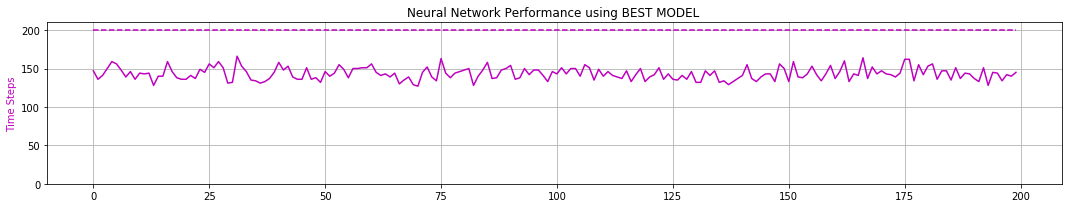

peak memory: 1466.57 MiB, increment: 1015.58 MiB
0 -max- [ 0.627  1.187  0.107  1.340]
0 -min- [-2.400 -2.794 -0.201 -1.288]

1 -max- [ 0.637  1.378  0.125  1.570]
1 -min- [-2.399 -2.612 -0.208 -1.539]

2 -max- [ 0.569  1.202  0.093  1.419]
2 -min- [-2.399 -2.695 -0.205 -1.539]

3 -max- [ 0.566  1.379  0.081  1.435]
3 -min- [-2.398 -2.731 -0.202 -1.587]

4 -max- [ 0.571  1.394  0.135  1.753]
4 -min- [-2.399 -2.615 -0.205 -1.657]

5 -max- [ 0.580  1.389  0.080  1.491]
5 -min- [-2.398 -2.748 -0.208 -1.537]

6 -max- [ 0.783  1.567  0.132  1.700]
6 -min- [-2.400 -2.699 -0.203 -1.637]

7 -max- [ 0.769  1.548  0.192  1.600]
7 -min- [-2.400 -2.733 -0.203 -1.532]

8 -max- [ 1.019  1.701  0.192  1.593]
8 -min- [-2.400 -2.770 -0.209 -1.516]

9 -max- [ 1.164  1.478  0.130  1.525]
9 -min- [-2.399 -2.604 -0.208 -1.644]

Quantization TIME:  0.02 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   114674
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 137
TOTAL SERIAL TIMESTEPS:   1538096
TOTAL PARALLEL 

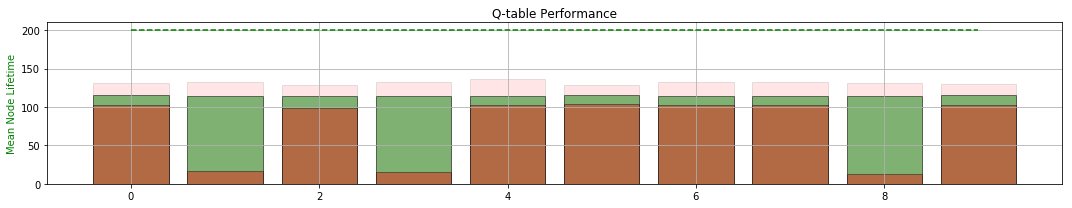

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 67.414	LOSS : 68.470	LOSS : 64.089	LOSS : 67.235	LOSS : 62.586	LOSS : 67.133	LOSS : 63.732	LOSS : 64.182	
Validating... MEAN TIME:  123.415
LOSS : 66.551	LOSS : 73.300	LOSS : 58.082	LOSS : 64.383	LOSS : 64.694	LOSS : 66.318	LOSS : 63.515	LOSS : 61.489	
Validating... MEAN TIME:  131.29
LOSS : 69.810	LOSS : 68.288	LOSS : 64.281	LOSS : 65.784	LOSS : 62.115	LOSS : 65.202	LOSS : 65.743	LOSS : 67.377	
Validating... MEAN TIME:  136.33
LOSS : 64.689	LOSS : 65.323	LOSS : 63.454	LOSS : 65.984	LOSS : 62.192	LOSS : 62.866	LOSS : 64.286	LOSS : 64.201	
Validating... MEAN TIME:  143.025
LOSS : 68.869	LOSS : 65.609	LOSS : 67.922	LOSS : 66.726	LOSS : 61.124	LOSS : 64.768	LOSS : 69.126	LOSS : 65.568	
Validating... MEAN TIME:  148.8
TRAINING TIME:0:01:06.972384


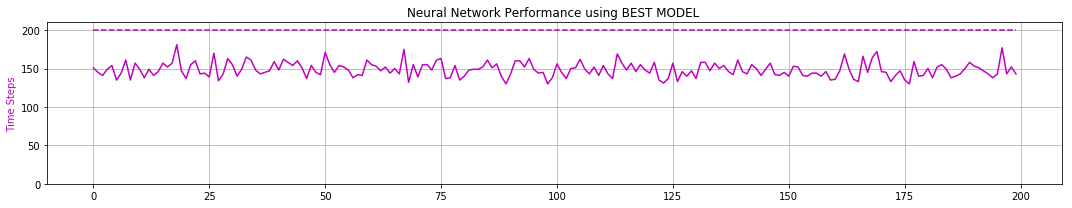

peak memory: 1443.24 MiB, increment: 1043.80 MiB
0 -max- [ 0.138  1.146  0.050  0.904]
0 -min- [-2.382 -2.535 -0.209 -1.659]

1 -max- [ 0.151  0.821  0.050  0.870]
1 -min- [-2.388 -2.560 -0.209 -1.356]

2 -max- [ 0.136  0.823  0.049  0.688]
2 -min- [-2.381 -2.589 -0.209 -1.214]

3 -max- [ 0.173  1.355  0.054  0.933]
3 -min- [-2.379 -2.594 -0.209 -1.906]

4 -max- [ 0.136  0.820  0.051  0.881]
4 -min- [-2.384 -2.501 -0.209 -1.208]

5 -max- [ 0.156  1.144  0.050  0.881]
5 -min- [-2.366 -2.426 -0.209 -1.664]

6 -max- [ 0.153  1.206  0.050  0.904]
6 -min- [-2.369 -2.593 -0.209 -1.656]

7 -max- [ 0.144  0.937  0.050  0.913]
7 -min- [-2.384 -2.573 -0.209 -1.416]

8 -max- [ 0.225  1.355  0.050  1.176]
8 -min- [-2.385 -2.603 -0.209 -1.948]

9 -max- [ 0.140  0.828  0.049  0.702]
9 -min- [-2.375 -2.531 -0.209 -1.167]

Quantization TIME:  0.02 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   124919
SMALLEST TIMESTEP: 101
LARGEST  TIMESTEP: 150
TOTAL SERIAL TIMESTEPS:   1663015
TOTAL PARALLEL

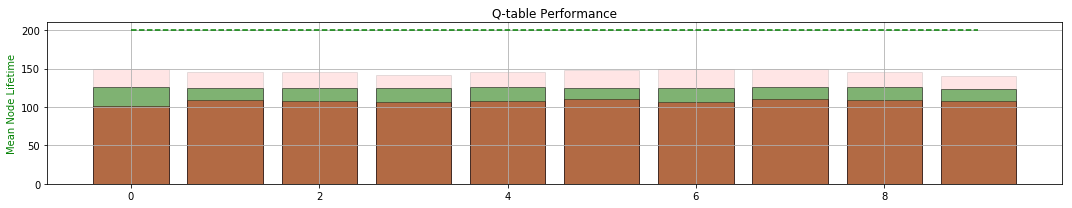

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 72.182	LOSS : 70.853	LOSS : 74.424	LOSS : 65.809	LOSS : 71.369	LOSS : 70.578	LOSS : 65.018	LOSS : 61.424	
Validating... MEAN TIME:  127.99
LOSS : 69.616	LOSS : 65.545	LOSS : 66.603	LOSS : 68.370	LOSS : 68.950	LOSS : 68.939	LOSS : 66.495	LOSS : 62.533	
Validating... MEAN TIME:  127.15
LOSS : 68.549	LOSS : 70.378	LOSS : 63.001	LOSS : 64.358	LOSS : 70.636	LOSS : 63.835	LOSS : 65.562	LOSS : 65.742	
Validating... MEAN TIME:  129.06
LOSS : 69.626	LOSS : 65.617	LOSS : 69.376	LOSS : 69.601	LOSS : 71.410	LOSS : 70.372	LOSS : 70.122	LOSS : 70.430	
Validating... MEAN TIME:  129.785
LOSS : 69.041	LOSS : 70.246	LOSS : 64.438	LOSS : 67.647	LOSS : 70.243	LOSS : 70.005	LOSS : 65.317	LOSS : 64.715	
Validating... MEAN TIME:  127.4
TRAINING TIME:0:01:07.732391


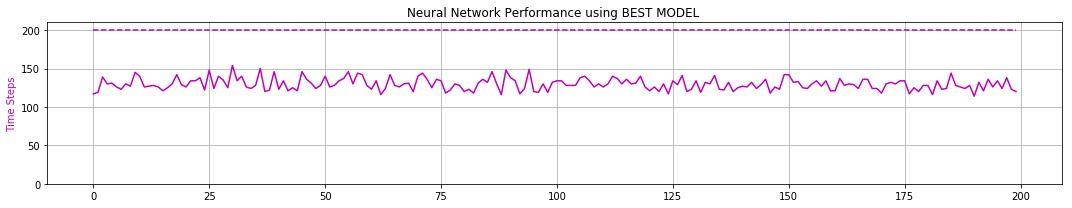

peak memory: 1440.51 MiB, increment: 977.40 MiB
0 -max- [ 0.138  0.793  0.050  0.696]
0 -min- [-2.398 -2.564 -0.209 -1.122]

1 -max- [ 0.151  1.168  0.055  0.712]
1 -min- [-2.395 -2.733 -0.209 -1.616]

2 -max- [ 0.108  0.812  0.050  0.679]
2 -min- [-2.400 -2.695 -0.209 -1.162]

3 -max- [ 0.122  0.824  0.050  0.812]
3 -min- [-2.398 -2.555 -0.209 -1.094]

4 -max- [ 0.116  0.775  0.050  0.674]
4 -min- [-2.400 -2.580 -0.209 -1.145]

5 -max- [ 0.126  0.823  0.048  0.708]
5 -min- [-2.399 -2.565 -0.209 -1.189]

6 -max- [ 0.131  0.633  0.050  0.677]
6 -min- [-2.400 -2.574 -0.209 -0.938]

7 -max- [ 0.137  0.631  0.050  0.827]
7 -min- [-2.399 -2.596 -0.209 -1.090]

8 -max- [ 0.120  0.760  0.049  0.890]
8 -min- [-2.398 -2.589 -0.209 -1.118]

9 -max- [ 0.167  1.006  0.053  0.685]
9 -min- [-2.399 -2.584 -0.209 -1.468]

Quantization TIME:  0.02 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   109049
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 129
TOTAL SERIAL TIMESTEPS:   1772064
TOTAL PARALLEL T

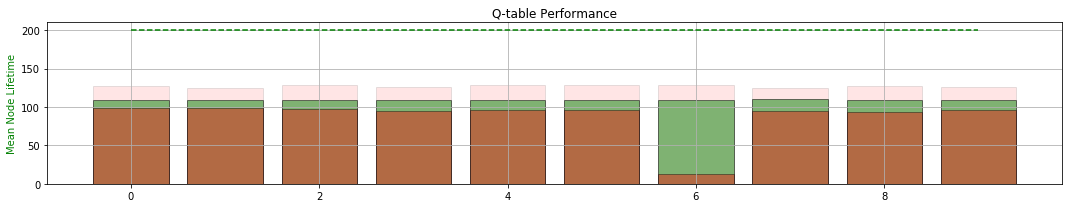

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 69.753	LOSS : 70.144	LOSS : 72.611	LOSS : 74.952	LOSS : 75.362	LOSS : 73.135	LOSS : 76.580	LOSS : 70.908	
Validating... MEAN TIME:  139.79
LOSS : 75.276	LOSS : 70.856	LOSS : 70.832	LOSS : 74.302	LOSS : 71.923	LOSS : 73.971	LOSS : 75.120	LOSS : 70.201	
Validating... MEAN TIME:  145.135
LOSS : 70.415	LOSS : 71.808	LOSS : 71.434	LOSS : 75.450	LOSS : 71.056	LOSS : 70.572	LOSS : 72.792	LOSS : 71.454	
Validating... MEAN TIME:  146.78
LOSS : 71.490	LOSS : 71.619	LOSS : 72.497	LOSS : 73.592	LOSS : 75.161	LOSS : 70.500	LOSS : 73.979	LOSS : 74.079	
Validating... MEAN TIME:  144.74
LOSS : 74.152	LOSS : 69.164	LOSS : 74.426	LOSS : 76.463	LOSS : 75.312	LOSS : 71.954	LOSS : 73.677	LOSS : 71.241	
Validating... MEAN TIME:  144.385
TRAINING TIME:0:01:09.728057


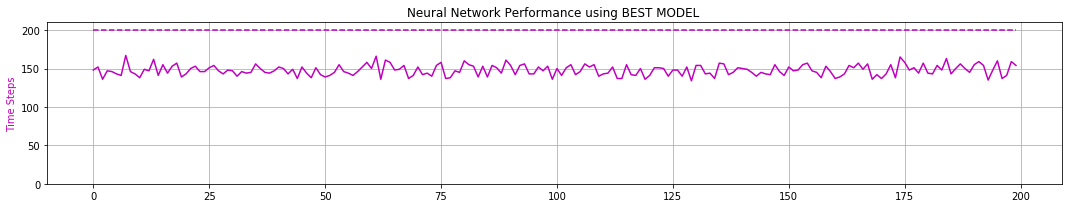

peak memory: 1443.96 MiB, increment: 1035.18 MiB
0 -max- [ 0.133  0.796  0.049  0.678]
0 -min- [-2.083 -2.416 -0.209 -1.195]

1 -max- [ 0.116  0.824  0.050  0.704]
1 -min- [-2.057 -2.408 -0.209 -1.119]

2 -max- [ 0.130  0.773  0.050  0.818]
2 -min- [-2.063 -2.389 -0.209 -1.156]

3 -max- [ 0.150  1.129  0.050  0.677]
3 -min- [-2.164 -2.582 -0.209 -1.657]

4 -max- [ 0.137  0.749  0.048  0.679]
4 -min- [-2.119 -2.404 -0.209 -1.155]

5 -max- [ 0.142  0.740  0.050  0.770]
5 -min- [-2.137 -2.577 -0.209 -1.101]

6 -max- [ 0.225  1.355  0.050  0.855]
6 -min- [-2.111 -2.406 -0.209 -1.948]

7 -max- [ 0.138  0.803  0.049  0.687]
7 -min- [-2.090 -2.555 -0.209 -1.166]

8 -max- [ 0.128  0.634  0.049  0.684]
8 -min- [-2.123 -2.573 -0.209 -1.004]

9 -max- [ 0.138  0.819  0.048  0.629]
9 -min- [-2.060 -2.412 -0.209 -1.192]

Quantization TIME:  0.02 minutes


ITERATION # 20
TOTAL EXPERIENCE GENERATED:   120634
SMALLEST TIMESTEP: 105
LARGEST  TIMESTEP: 139
TOTAL SERIAL TIMESTEPS:   1892698
TOTAL PARALLEL

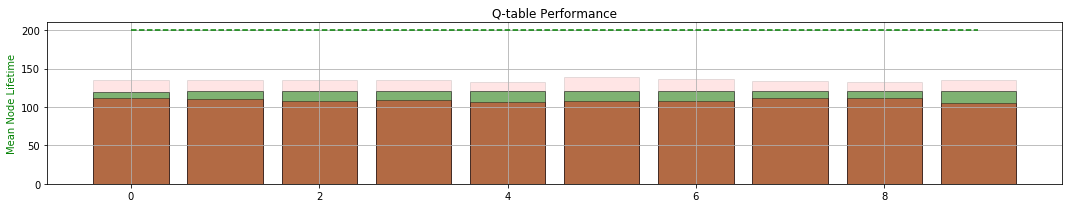

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 75.981	LOSS : 74.821	LOSS : 73.551	LOSS : 76.469	LOSS : 74.994	LOSS : 81.986	LOSS : 78.965	LOSS : 75.135	
Validating... MEAN TIME:  132.635
LOSS : 73.744	LOSS : 78.260	LOSS : 77.368	LOSS : 76.746	LOSS : 78.193	LOSS : 73.987	LOSS : 80.637	LOSS : 77.126	
Validating... MEAN TIME:  134.005
LOSS : 74.396	LOSS : 73.299	LOSS : 81.973	LOSS : 76.508	LOSS : 78.309	LOSS : 73.941	LOSS : 78.747	LOSS : 77.267	
Validating... MEAN TIME:  133.22
LOSS : 74.777	LOSS : 73.262	LOSS : 72.725	LOSS : 74.145	LOSS : 73.882	LOSS : 78.732	LOSS : 74.647	LOSS : 76.848	
Validating... MEAN TIME:  135.135
LOSS : 77.566	LOSS : 75.954	LOSS : 74.062	LOSS : 72.489	LOSS : 74.186	LOSS : 76.640	LOSS : 74.993	LOSS : 73.385	
Validating... MEAN TIME:  133.15
TRAINING TIME:0:01:09.523235


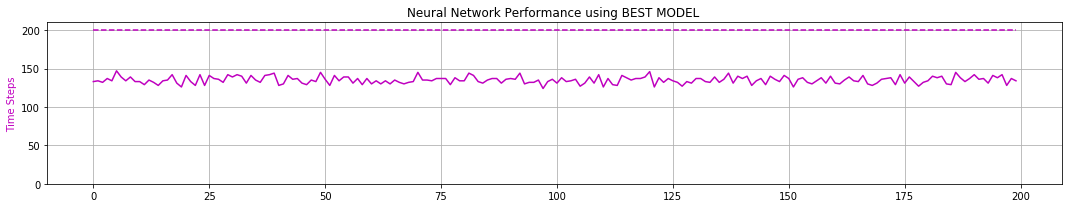

peak memory: 1449.19 MiB, increment: 981.68 MiB
0 -max- [ 0.131  0.630  0.050  0.754]
0 -min- [-2.399 -2.529 -0.209 -0.927]

1 -max- [ 0.135  0.627  0.050  0.644]
1 -min- [-2.400 -2.413 -0.209 -0.912]

2 -max- [ 0.132  0.631  0.050  0.609]
2 -min- [-2.400 -2.406 -0.209 -1.132]

3 -max- [ 0.146  0.629  0.048  0.654]
3 -min- [-2.399 -2.422 -0.209 -0.962]

4 -max- [ 0.144  0.806  0.050  0.679]
4 -min- [-2.399 -2.408 -0.209 -1.112]

5 -max- [ 0.149  0.631  0.050  0.687]
5 -min- [-2.400 -2.594 -0.209 -1.093]

6 -max- [ 0.137  0.634  0.049  0.690]
6 -min- [-2.399 -2.408 -0.209 -0.925]

7 -max- [ 0.139  0.632  0.049  0.687]
7 -min- [-2.399 -2.513 -0.209 -0.973]

8 -max- [ 0.134  0.629  0.048  0.634]
8 -min- [-2.399 -2.411 -0.209 -1.075]

9 -max- [ 0.151  0.753  0.052  0.691]
9 -min- [-2.400 -2.414 -0.209 -1.054]

Quantization TIME:  0.02 minutes


ITERATION # 21
TOTAL EXPERIENCE GENERATED:   109639
SMALLEST TIMESTEP: 31
LARGEST  TIMESTEP: 125
TOTAL SERIAL TIMESTEPS:   2002337
TOTAL PARALLEL T

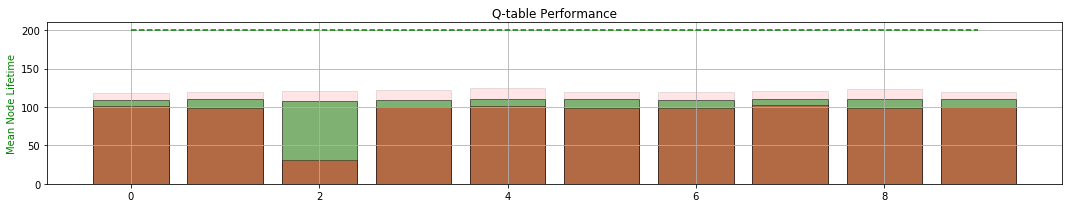

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 75.277	LOSS : 73.054	LOSS : 74.639	LOSS : 76.632	LOSS : 74.719	LOSS : 79.331	LOSS : 74.825	LOSS : 79.114	
Validating... MEAN TIME:  118.195
LOSS : 74.090	LOSS : 74.219	LOSS : 73.635	LOSS : 75.815	LOSS : 73.084	LOSS : 74.843	LOSS : 75.741	LOSS : 75.530	
Validating... MEAN TIME:  118.615
LOSS : 74.526	LOSS : 70.382	LOSS : 73.180	LOSS : 74.176	LOSS : 71.903	LOSS : 72.358	LOSS : 73.740	LOSS : 74.311	
Validating... MEAN TIME:  116.305
LOSS : 74.516	LOSS : 76.157	LOSS : 69.632	LOSS : 71.934	LOSS : 71.433	LOSS : 72.388	LOSS : 69.996	LOSS : 71.202	
Validating... MEAN TIME:  115.02
LOSS : 74.233	LOSS : 74.494	LOSS : 71.979	LOSS : 73.296	LOSS : 72.726	LOSS : 69.781	LOSS : 70.625	LOSS : 69.904	
Validating... MEAN TIME:  112.685
TRAINING TIME:0:01:06.462278


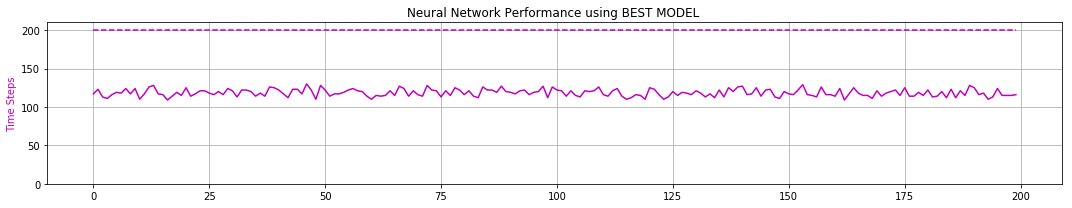

peak memory: 1504.47 MiB, increment: 1070.86 MiB
0 -max- [ 0.147  0.632  0.050  0.700]
0 -min- [-2.400 -2.539 -0.176 -0.925]

1 -max- [ 0.142  0.631  0.050  0.827]
1 -min- [-2.400 -2.626 -0.202 -0.915]

2 -max- [ 0.171  0.632  0.048  0.858]
2 -min- [-2.400 -2.547 -0.208 -1.006]

3 -max- [ 0.162  0.629  0.050  0.843]
3 -min- [-2.400 -2.548 -0.202 -0.943]

4 -max- [ 0.162  0.769  0.050  0.723]
4 -min- [-2.399 -2.531 -0.198 -1.058]

5 -max- [ 0.147  0.634  0.049  0.720]
5 -min- [-2.400 -2.598 -0.199 -0.912]

6 -max- [ 0.148  0.631  0.049  0.857]
6 -min- [-2.400 -2.563 -0.199 -0.996]

7 -max- [ 0.149  0.635  0.048  0.930]
7 -min- [-2.399 -2.731 -0.193 -0.941]

8 -max- [ 0.174  0.633  0.050  0.838]
8 -min- [-2.399 -2.625 -0.187 -0.983]

9 -max- [ 0.160  0.633  0.049  0.697]
9 -min- [-2.400 -2.529 -0.204 -0.979]

Quantization TIME:  0.01 minutes


ITERATION # 22
TOTAL EXPERIENCE GENERATED:   105252
SMALLEST TIMESTEP: 95
LARGEST  TIMESTEP: 119
TOTAL SERIAL TIMESTEPS:   2107589
TOTAL PARALLEL 

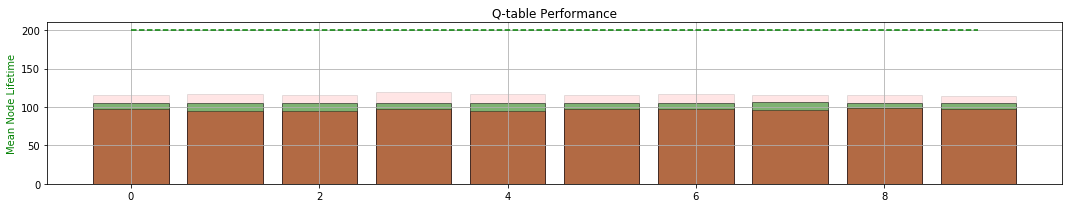

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 76.489	LOSS : 78.964	LOSS : 73.196	LOSS : 79.396	LOSS : 76.883	LOSS : 76.241	LOSS : 81.109	LOSS : 81.571	
Validating... MEAN TIME:  103.025
LOSS : 73.253	LOSS : 71.278	LOSS : 73.972	LOSS : 78.610	LOSS : 77.613	LOSS : 75.434	LOSS : 73.731	LOSS : 71.766	
Validating... MEAN TIME:  110.345
LOSS : 75.443	LOSS : 74.525	LOSS : 78.549	LOSS : 76.085	LOSS : 78.968	LOSS : 76.160	LOSS : 75.936	LOSS : 77.459	
Validating... MEAN TIME:  115.16
LOSS : 74.023	LOSS : 74.468	LOSS : 77.510	LOSS : 80.539	LOSS : 74.804	LOSS : 74.187	LOSS : 72.671	LOSS : 75.577	
Validating... MEAN TIME:  114.99
LOSS : 76.839	LOSS : 74.833	LOSS : 73.197	LOSS : 79.846	LOSS : 76.222	LOSS : 75.333	LOSS : 73.580	LOSS : 72.488	
Validating... MEAN TIME:  115.81
TRAINING TIME:0:01:05.786822


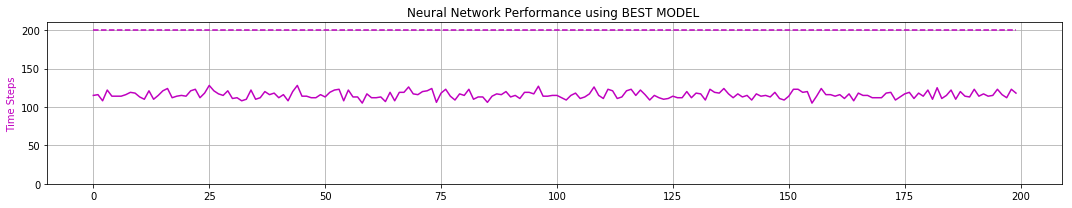

peak memory: 1470.97 MiB, increment: 978.66 MiB
0 -max- [ 0.158  0.809  0.050  0.673]
0 -min- [-2.400 -2.980 -0.209 -1.128]

1 -max- [ 0.150  0.763  0.048  0.895]
1 -min- [-2.400 -2.996 -0.190 -1.172]

2 -max- [ 0.155  0.740  0.050  0.703]
2 -min- [-2.400 -2.974 -0.204 -1.109]

3 -max- [ 0.154  0.774  0.050  0.828]
3 -min- [-2.400 -2.948 -0.195 -1.163]

4 -max- [ 0.140  0.787  0.049  0.807]
4 -min- [-2.399 -2.956 -0.186 -1.075]

5 -max- [ 0.144  0.631  0.049  0.728]
5 -min- [-2.399 -2.975 -0.198 -0.923]

6 -max- [ 0.141  0.760  0.048  0.681]
6 -min- [-2.400 -2.955 -0.185 -1.094]

7 -max- [ 0.153  0.824  0.050  0.901]
7 -min- [-2.400 -2.960 -0.206 -1.117]

8 -max- [ 0.147  0.770  0.049  0.716]
8 -min- [-2.400 -2.978 -0.205 -1.134]

9 -max- [ 0.151  0.635  0.050  0.693]
9 -min- [-2.400 -2.959 -0.195 -0.930]

Quantization TIME:  0.02 minutes


ITERATION # 23
TOTAL EXPERIENCE GENERATED:   107410
SMALLEST TIMESTEP: 62
LARGEST  TIMESTEP: 122
TOTAL SERIAL TIMESTEPS:   2214999
TOTAL PARALLEL T

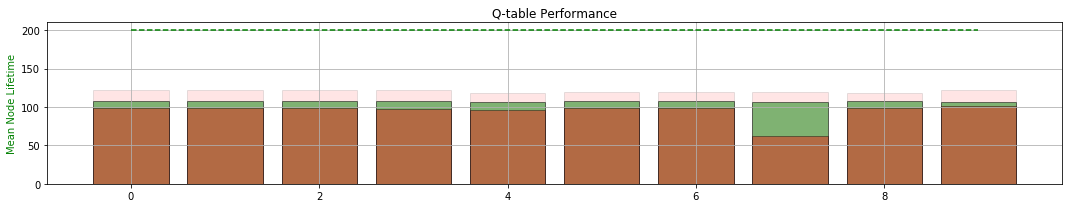

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 76.832	LOSS : 79.943	LOSS : 72.357	LOSS : 81.234	LOSS : 69.745	LOSS : 78.280	LOSS : 74.944	LOSS : 73.570	
Validating... MEAN TIME:  111.225
LOSS : 75.841	LOSS : 72.251	LOSS : 78.095	LOSS : 70.758	LOSS : 71.552	LOSS : 70.617	LOSS : 73.275	LOSS : 77.858	
Validating... MEAN TIME:  112.36
LOSS : 66.503	LOSS : 69.135	LOSS : 73.263	LOSS : 73.093	LOSS : 76.782	LOSS : 68.029	LOSS : 69.128	LOSS : 77.332	
Validating... MEAN TIME:  111.22
LOSS : 73.072	LOSS : 70.475	LOSS : 74.729	LOSS : 74.788	LOSS : 72.401	LOSS : 73.062	LOSS : 74.148	LOSS : 73.721	
Validating... MEAN TIME:  110.0
LOSS : 68.062	LOSS : 68.549	LOSS : 76.855	LOSS : 76.297	LOSS : 70.694	LOSS : 74.626	LOSS : 74.341	LOSS : 69.320	
Validating... MEAN TIME:  109.205
TRAINING TIME:0:01:04.819770


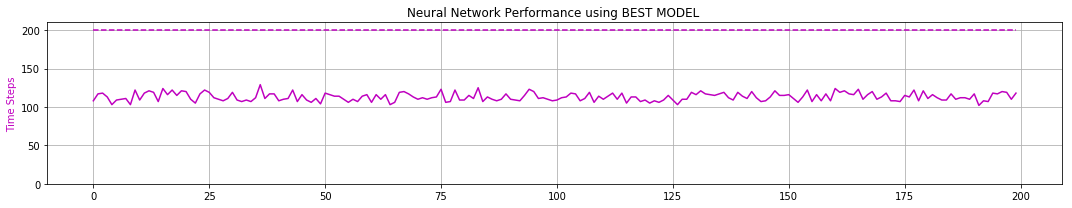

peak memory: 1490.50 MiB, increment: 978.09 MiB
0 -max- [ 0.145  0.755  0.052  0.765]
0 -min- [-2.399 -3.088 -0.192 -1.041]

1 -max- [ 0.142  0.823  0.050  0.696]
1 -min- [-2.397 -3.116 -0.204 -1.181]

2 -max- [ 0.150  0.825  0.050  0.835]
2 -min- [-2.400 -3.144 -0.203 -1.124]

3 -max- [ 0.137  0.787  0.049  0.667]
3 -min- [-2.400 -3.108 -0.183 -1.152]

4 -max- [ 0.129  0.801  0.049  0.661]
4 -min- [-2.400 -3.159 -0.199 -1.161]

5 -max- [ 0.134  0.764  0.048  0.631]
5 -min- [-2.400 -3.075 -0.192 -1.177]

6 -max- [ 0.151  0.639  0.050  0.685]
6 -min- [-2.399 -3.161 -0.194 -0.950]

7 -max- [ 0.148  0.634  0.050  0.696]
7 -min- [-2.400 -3.167 -0.197 -1.137]

8 -max- [ 0.143  0.803  0.050  0.643]
8 -min- [-2.399 -3.108 -0.186 -1.193]

9 -max- [ 0.123  0.633  0.050  0.601]
9 -min- [-2.400 -3.082 -0.176 -0.916]

Quantization TIME:  0.02 minutes


ITERATION # 24
TOTAL EXPERIENCE GENERATED:   93684
SMALLEST TIMESTEP: 68
LARGEST  TIMESTEP: 114
TOTAL SERIAL TIMESTEPS:   2308683
TOTAL PARALLEL TI

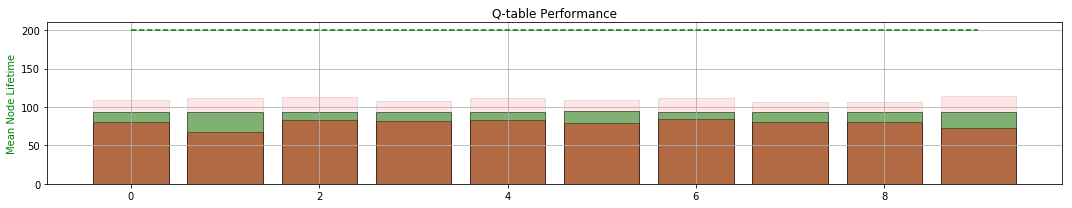

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 84.849	LOSS : 83.592	LOSS : 76.022	LOSS : 78.712	LOSS : 85.742	LOSS : 75.193	LOSS : 78.937	LOSS : 78.118	
Validating... MEAN TIME:  119.07
LOSS : 79.475	LOSS : 81.324	LOSS : 77.766	LOSS : 78.911	LOSS : 83.578	LOSS : 82.405	LOSS : 81.193	LOSS : 82.134	
Validating... MEAN TIME:  128.025
LOSS : 79.565	LOSS : 76.004	LOSS : 79.539	LOSS : 82.060	LOSS : 76.272	LOSS : 78.520	LOSS : 77.205	LOSS : 81.942	
Validating... MEAN TIME:  127.48
LOSS : 77.622	LOSS : 77.783	LOSS : 86.444	LOSS : 83.609	LOSS : 78.075	LOSS : 79.057	LOSS : 77.370	LOSS : 75.847	
Validating... MEAN TIME:  125.605
LOSS : 81.895	LOSS : 80.098	LOSS : 76.111	LOSS : 85.011	LOSS : 78.655	LOSS : 78.361	LOSS : 81.587	LOSS : 83.145	
Validating... MEAN TIME:  125.94
TRAINING TIME:0:01:05.577732


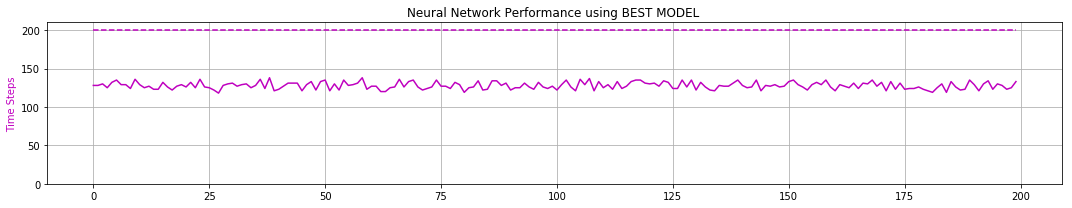

peak memory: 1453.84 MiB, increment: 1015.58 MiB
0 -max- [ 0.152  0.824  0.050  0.658]
0 -min- [-2.351 -3.101 -0.209 -1.169]

1 -max- [ 0.154  0.825  0.050  0.738]
1 -min- [-2.373 -3.138 -0.209 -1.165]

2 -max- [ 0.140  0.828  0.049  0.603]
2 -min- [-2.388 -3.261 -0.209 -1.167]

3 -max- [ 0.136  0.923  0.056  0.629]
3 -min- [-2.364 -3.149 -0.209 -1.352]

4 -max- [ 0.142  0.824  0.048  0.686]
4 -min- [-2.357 -3.089 -0.209 -1.179]

5 -max- [ 0.153  0.825  0.050  0.696]
5 -min- [-2.050 -2.743 -0.209 -1.167]

6 -max- [ 0.145  0.828  0.049  0.665]
6 -min- [-2.347 -3.067 -0.209 -1.174]

7 -max- [ 0.145  0.957  0.050  0.667]
7 -min- [-2.346 -3.142 -0.209 -1.359]

8 -max- [ 0.131  0.816  0.050  0.631]
8 -min- [-2.230 -2.885 -0.209 -1.158]

9 -max- [ 0.147  0.823  0.050  0.665]
9 -min- [-2.370 -3.100 -0.209 -1.164]

Quantization TIME:  0.01 minutes


ITERATION # 25
TOTAL EXPERIENCE GENERATED:   108799
SMALLEST TIMESTEP: 28
LARGEST  TIMESTEP: 123
TOTAL SERIAL TIMESTEPS:   2417482
TOTAL PARALLEL 

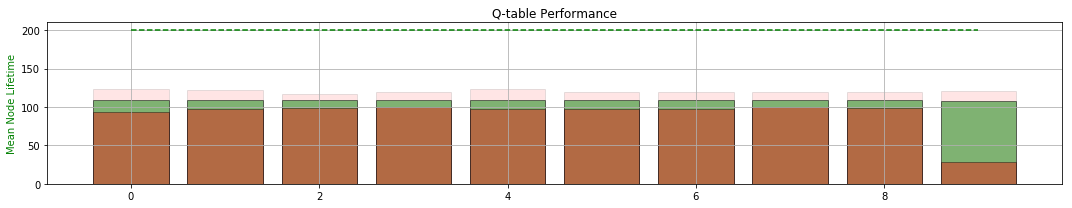

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 80.439	LOSS : 80.838	LOSS : 80.630	LOSS : 85.191	LOSS : 80.262	LOSS : 81.551	LOSS : 86.820	LOSS : 82.063	
Validating... MEAN TIME:  109.225
LOSS : 83.204	LOSS : 79.813	LOSS : 83.820	LOSS : 85.426	LOSS : 86.089	LOSS : 77.309	LOSS : 86.665	LOSS : 81.383	
Validating... MEAN TIME:  108.575
LOSS : 81.721	LOSS : 81.182	LOSS : 79.871	LOSS : 83.088	LOSS : 81.021	LOSS : 82.093	LOSS : 81.715	LOSS : 79.393	
Validating... MEAN TIME:  108.4
LOSS : 79.328	LOSS : 77.019	LOSS : 82.987	LOSS : 82.949	LOSS : 84.357	LOSS : 79.518	LOSS : 79.406	LOSS : 78.404	
Validating... MEAN TIME:  108.97
LOSS : 81.035	LOSS : 84.070	LOSS : 82.594	LOSS : 80.432	LOSS : 80.903	LOSS : 83.817	LOSS : 80.234	LOSS : 80.689	
Validating... MEAN TIME:  110.865
TRAINING TIME:0:01:04.256770


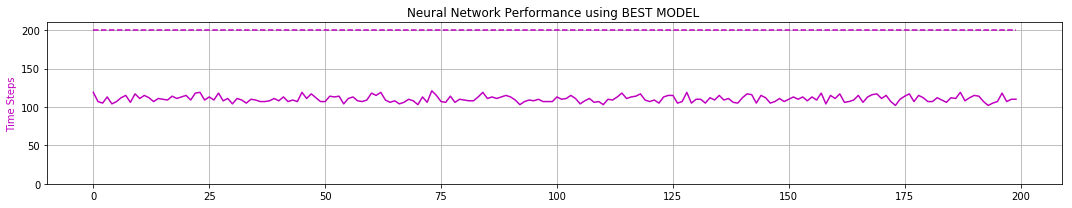

peak memory: 1464.67 MiB, increment: 1036.70 MiB
0 -max- [ 0.154  0.828  0.053  0.667]
0 -min- [-2.399 -2.537 -0.209 -1.213]

1 -max- [ 0.140  0.797  0.049  0.666]
1 -min- [-2.398 -2.577 -0.209 -1.113]

2 -max- [ 0.143  0.634  0.049  0.866]
2 -min- [-2.398 -2.608 -0.209 -1.033]

3 -max- [ 0.141  0.639  0.048  0.681]
3 -min- [-2.399 -2.535 -0.209 -1.052]

4 -max- [ 0.161  0.767  0.050  0.909]
4 -min- [-2.396 -2.554 -0.209 -1.216]

5 -max- [ 0.152  0.811  0.049  0.884]
5 -min- [-2.397 -2.522 -0.209 -1.161]

6 -max- [ 0.145  0.635  0.050  0.645]
6 -min- [-2.397 -2.583 -0.209 -1.191]

7 -max- [ 0.144  0.633  0.050  0.814]
7 -min- [-2.399 -2.564 -0.209 -1.028]

8 -max- [ 0.155  0.784  0.049  0.670]
8 -min- [-2.399 -2.560 -0.209 -1.110]

9 -max- [ 0.158  0.824  0.048  0.673]
9 -min- [-2.399 -2.563 -0.209 -1.164]

Quantization TIME:  0.01 minutes


ITERATION # 26
TOTAL EXPERIENCE GENERATED:   95885
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 107
TOTAL SERIAL TIMESTEPS:   2513367
TOTAL PARALLEL T

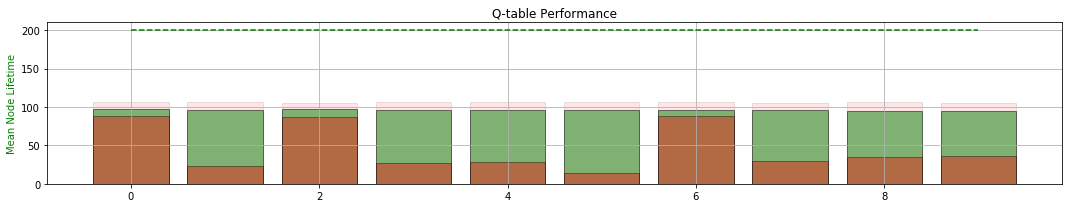

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 82.788	LOSS : 78.143	LOSS : 79.064	LOSS : 83.775	LOSS : 81.111	LOSS : 81.240	LOSS : 86.189	LOSS : 81.558	
Validating... MEAN TIME:  106.33
LOSS : 81.405	LOSS : 81.705	LOSS : 76.018	LOSS : 77.365	LOSS : 77.388	LOSS : 78.746	LOSS : 78.093	LOSS : 74.982	
Validating... MEAN TIME:  107.4
LOSS : 77.266	LOSS : 71.499	LOSS : 77.642	LOSS : 76.434	LOSS : 77.802	LOSS : 76.286	LOSS : 79.720	LOSS : 78.458	
Validating... MEAN TIME:  109.145
LOSS : 75.768	LOSS : 82.946	LOSS : 78.809	LOSS : 80.682	LOSS : 75.699	LOSS : 71.782	LOSS : 78.350	LOSS : 82.424	
Validating... MEAN TIME:  109.23
LOSS : 75.021	LOSS : 82.021	LOSS : 79.027	LOSS : 74.669	LOSS : 78.843	LOSS : 80.307	LOSS : 78.669	LOSS : 78.013	
Validating... MEAN TIME:  110.305
TRAINING TIME:0:01:04.328628


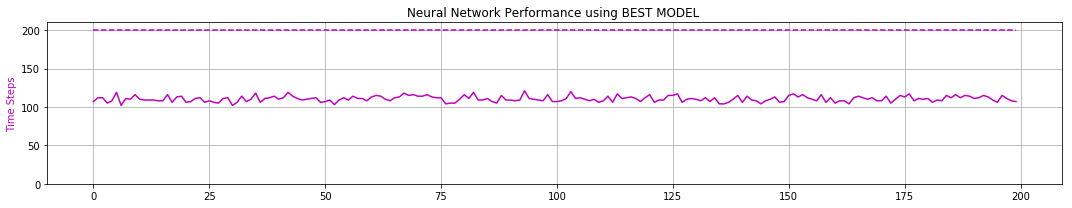

peak memory: 1464.66 MiB, increment: 977.97 MiB
0 -max- [ 0.155  0.639  0.049  0.681]
0 -min- [-2.268 -2.682 -0.209 -1.058]

1 -max- [ 0.170  0.995  0.063  0.675]
1 -min- [-2.281 -2.597 -0.209 -1.351]

2 -max- [ 0.153  0.820  0.048  0.668]
2 -min- [-2.245 -2.594 -0.209 -1.114]

3 -max- [ 0.169  0.793  0.050  0.808]
3 -min- [-2.254 -2.778 -0.209 -1.115]

4 -max- [ 0.163  0.783  0.049  0.689]
4 -min- [-2.336 -2.756 -0.209 -1.181]

5 -max- [ 0.161  0.957  0.050  0.655]
5 -min- [-2.288 -2.681 -0.209 -1.370]

6 -max- [ 0.148  0.735  0.050  0.669]
6 -min- [-2.245 -2.595 -0.209 -1.130]

7 -max- [ 0.158  0.752  0.049  0.635]
7 -min- [-2.254 -2.720 -0.209 -1.149]

8 -max- [ 0.159  0.763  0.048  0.792]
8 -min- [-2.296 -2.758 -0.209 -1.217]

9 -max- [ 0.148  0.771  0.049  0.625]
9 -min- [-2.369 -2.967 -0.209 -1.093]

Quantization TIME:  0.01 minutes


ITERATION # 27
TOTAL EXPERIENCE GENERATED:   99992
SMALLEST TIMESTEP: 21
LARGEST  TIMESTEP: 112
TOTAL SERIAL TIMESTEPS:   2613359
TOTAL PARALLEL TI

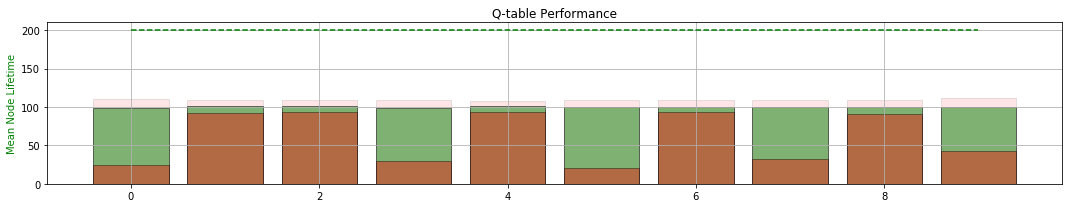

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 77.549	LOSS : 79.902	LOSS : 86.156	LOSS : 79.069	LOSS : 81.631	LOSS : 82.035	LOSS : 81.428	LOSS : 75.166	
Validating... MEAN TIME:  118.035
LOSS : 79.157	LOSS : 77.662	LOSS : 79.125	LOSS : 86.372	LOSS : 82.850	LOSS : 75.728	LOSS : 82.249	LOSS : 79.752	
Validating... MEAN TIME:  120.11
LOSS : 72.056	LOSS : 78.117	LOSS : 84.174	LOSS : 80.192	LOSS : 79.483	LOSS : 79.818	LOSS : 80.189	LOSS : 80.189	
Validating... MEAN TIME:  122.135
LOSS : 84.196	LOSS : 80.623	LOSS : 83.345	LOSS : 80.472	LOSS : 75.794	LOSS : 78.410	LOSS : 79.475	LOSS : 76.199	
Validating... MEAN TIME:  122.46
LOSS : 79.548	LOSS : 79.471	LOSS : 78.626	LOSS : 75.512	LOSS : 80.156	LOSS : 78.646	LOSS : 81.427	LOSS : 77.716	
Validating... MEAN TIME:  118.375
TRAINING TIME:0:01:05.007093


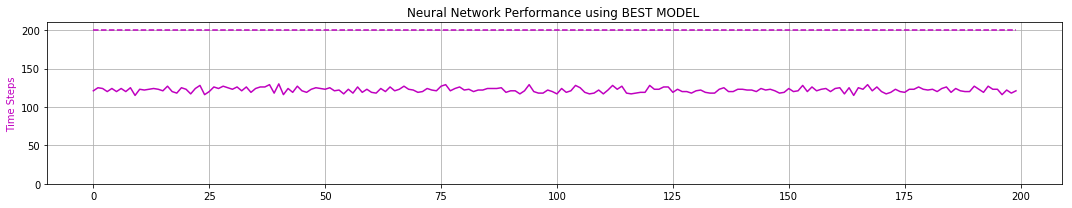

peak memory: 1490.03 MiB, increment: 1042.16 MiB
0 -max- [ 0.147  0.814  0.049  0.764]
0 -min- [-2.369 -2.727 -0.209 -1.192]

1 -max- [ 0.150  0.824  0.048  0.662]
1 -min- [-2.389 -2.760 -0.209 -1.166]

2 -max- [ 0.163  0.986  0.057  0.814]
2 -min- [-2.396 -2.799 -0.209 -1.339]

3 -max- [ 0.160  0.951  0.049  0.681]
3 -min- [-2.392 -2.773 -0.209 -1.395]

4 -max- [ 0.161  0.957  0.050  0.690]
4 -min- [-2.379 -2.754 -0.209 -1.359]

5 -max- [ 0.148  0.823  0.050  0.690]
5 -min- [-2.391 -2.759 -0.209 -1.247]

6 -max- [ 0.158  0.824  0.049  0.683]
6 -min- [-2.377 -2.719 -0.209 -1.176]

7 -max- [ 0.152  0.827  0.048  0.674]
7 -min- [-2.372 -2.701 -0.209 -1.208]

8 -max- [ 0.143  0.827  0.049  0.669]
8 -min- [-2.387 -2.719 -0.209 -1.166]

9 -max- [ 0.151  0.807  0.050  0.656]
9 -min- [-2.378 -2.728 -0.209 -1.310]

Quantization TIME:  0.01 minutes


ITERATION # 28
TOTAL EXPERIENCE GENERATED:   106325
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 117
TOTAL SERIAL TIMESTEPS:   2719684
TOTAL PARALLEL 

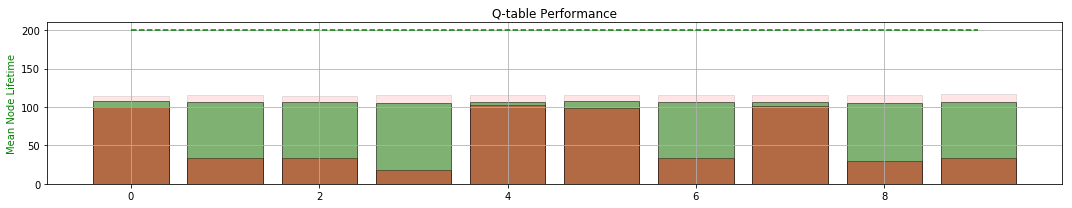

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 78.753	LOSS : 76.775	LOSS : 81.250	LOSS : 78.818	LOSS : 79.742	LOSS : 79.823	LOSS : 78.000	LOSS : 77.178	
Validating... MEAN TIME:  105.455
LOSS : 80.873	LOSS : 79.198	LOSS : 77.945	LOSS : 80.924	LOSS : 83.406	LOSS : 78.950	LOSS : 82.141	LOSS : 83.162	
Validating... MEAN TIME:  107.22
LOSS : 83.317	LOSS : 83.016	LOSS : 76.096	LOSS : 80.132	LOSS : 77.837	LOSS : 80.494	LOSS : 82.484	LOSS : 80.432	
Validating... MEAN TIME:  106.52
LOSS : 79.471	LOSS : 81.975	LOSS : 82.369	LOSS : 85.657	LOSS : 83.460	LOSS : 80.272	LOSS : 87.861	LOSS : 77.152	
Validating... MEAN TIME:  106.195
LOSS : 76.180	LOSS : 82.715	LOSS : 82.706	LOSS : 75.554	LOSS : 85.492	LOSS : 79.899	LOSS : 75.712	LOSS : 77.495	
Validating... MEAN TIME:  105.39
TRAINING TIME:0:00:57.707220


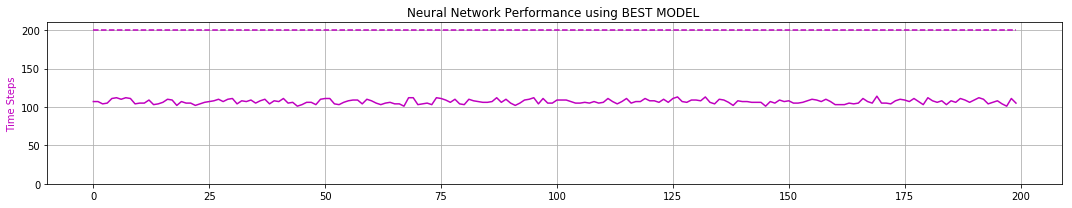

peak memory: 1446.56 MiB, increment: 972.11 MiB
0 -max- [ 0.150  0.778  0.048  0.897]
0 -min- [-2.399 -2.408 -0.209 -1.405]

1 -max- [ 0.169  0.793  0.050  0.910]
1 -min- [-2.400 -2.417 -0.207 -1.204]

2 -max- [ 0.160  0.828  0.049  0.910]
2 -min- [-2.400 -2.418 -0.208 -1.228]

3 -max- [ 0.163  0.826  0.050  0.899]
3 -min- [-2.399 -2.425 -0.208 -1.369]

4 -max- [ 0.144  0.735  0.050  0.775]
4 -min- [-2.399 -2.389 -0.209 -1.122]

5 -max- [ 0.158  0.805  0.049  0.811]
5 -min- [-2.399 -2.395 -0.207 -1.208]

6 -max- [ 0.158  0.794  0.048  0.794]
6 -min- [-2.400 -2.424 -0.208 -1.184]

7 -max- [ 0.143  0.774  0.049  0.786]
7 -min- [-2.400 -2.411 -0.207 -1.203]

8 -max- [ 0.148  0.794  0.050  0.868]
8 -min- [-2.400 -2.394 -0.209 -1.154]

9 -max- [ 0.158  0.819  0.050  0.864]
9 -min- [-2.399 -2.425 -0.209 -1.178]

Quantization TIME:  0.01 minutes


ITERATION # 29
TOTAL EXPERIENCE GENERATED:   79403
SMALLEST TIMESTEP: 24
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   2799087
TOTAL PARALLEL TI

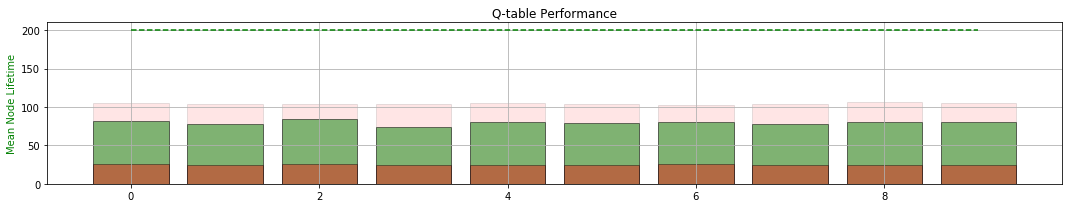

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 88.065	LOSS : 92.413	LOSS : 91.585	LOSS : 89.200	LOSS : 92.883	LOSS : 91.359	LOSS : 89.525	LOSS : 90.862	
Validating... MEAN TIME:  107.96
LOSS : 87.822	LOSS : 90.152	LOSS : 88.391	LOSS : 88.099	LOSS : 88.791	LOSS : 92.419	LOSS : 92.439	LOSS : 89.197	
Validating... MEAN TIME:  107.26
LOSS : 94.898	LOSS : 88.178	LOSS : 95.138	LOSS : 89.736	LOSS : 91.509	LOSS : 90.830	LOSS : 87.976	LOSS : 95.932	
Validating... MEAN TIME:  107.65
LOSS : 91.848	LOSS : 87.689	LOSS : 92.169	LOSS : 84.724	LOSS : 89.431	LOSS : 87.154	LOSS : 92.953	LOSS : 86.466	
Validating... MEAN TIME:  107.88
LOSS : 84.426	LOSS : 85.651	LOSS : 95.771	LOSS : 89.407	LOSS : 86.974	LOSS : 89.042	LOSS : 87.048	LOSS : 89.348	
Validating... MEAN TIME:  109.565
TRAINING TIME:0:00:58.607666


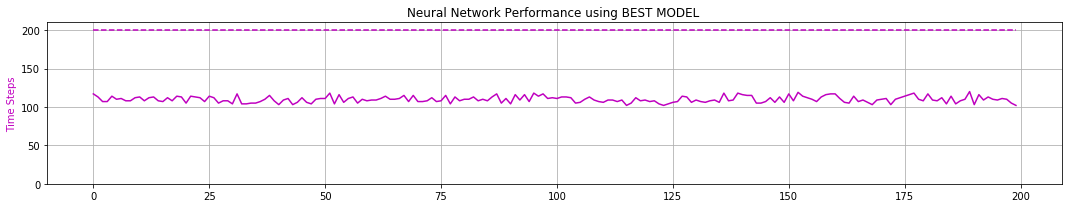

peak memory: 1491.18 MiB, increment: 977.55 MiB
0 -max- [ 0.179  1.005  0.050  0.815]
0 -min- [-2.400 -2.893 -0.209 -1.419]

1 -max- [ 0.176  1.006  0.049  0.823]
1 -min- [-2.400 -2.892 -0.209 -1.389]

2 -max- [ 0.175  0.957  0.050  0.793]
2 -min- [-2.400 -2.757 -0.209 -1.359]

3 -max- [ 0.157  0.828  0.050  0.692]
3 -min- [-2.400 -2.744 -0.209 -1.179]

4 -max- [ 0.174  0.825  0.049  0.661]
4 -min- [-2.400 -2.755 -0.209 -1.170]

5 -max- [ 0.171  0.993  0.048  0.822]
5 -min- [-2.400 -2.795 -0.209 -1.364]

6 -max- [ 0.162  0.827  0.049  0.649]
6 -min- [-2.400 -2.753 -0.209 -1.172]

7 -max- [ 0.167  0.930  0.050  0.752]
7 -min- [-2.398 -2.951 -0.209 -1.357]

8 -max- [ 0.174  0.819  0.050  0.903]
8 -min- [-2.400 -2.741 -0.209 -1.228]

9 -max- [ 0.182  0.822  0.050  0.662]
9 -min- [-2.400 -2.748 -0.209 -1.238]

Quantization TIME:  0.01 minutes


ITERATION # 30
TOTAL EXPERIENCE GENERATED:   101202
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 115
TOTAL SERIAL TIMESTEPS:   2900289
TOTAL PARALLEL T

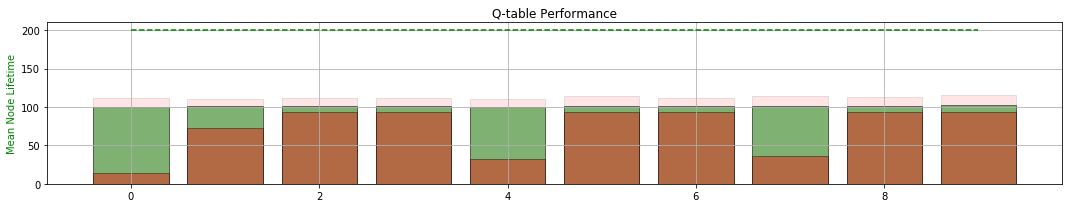

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 86.535	LOSS : 85.284	LOSS : 85.983	LOSS : 86.946	LOSS : 86.671	LOSS : 87.371	LOSS : 88.900	LOSS : 84.529	
Validating... MEAN TIME:  107.765
LOSS : 86.019	LOSS : 84.038	LOSS : 89.452	LOSS : 85.928	LOSS : 87.962	LOSS : 83.003	LOSS : 82.830	LOSS : 84.012	
Validating... MEAN TIME:  104.935
LOSS : 82.475	LOSS : 84.410	LOSS : 84.428	LOSS : 86.921	LOSS : 85.927	LOSS : 88.110	LOSS : 87.239	LOSS : 84.589	
Validating... MEAN TIME:  103.55
LOSS : 83.790	LOSS : 83.499	LOSS : 82.994	LOSS : 89.595	LOSS : 87.862	LOSS : 88.127	LOSS : 89.236	LOSS : 86.818	
Validating... MEAN TIME:  103.235
LOSS : 85.764	LOSS : 84.628	LOSS : 84.417	LOSS : 88.139	LOSS : 84.408	LOSS : 87.222	LOSS : 83.492	LOSS : 86.295	
Validating... MEAN TIME:  102.925
TRAINING TIME:0:00:57.945211


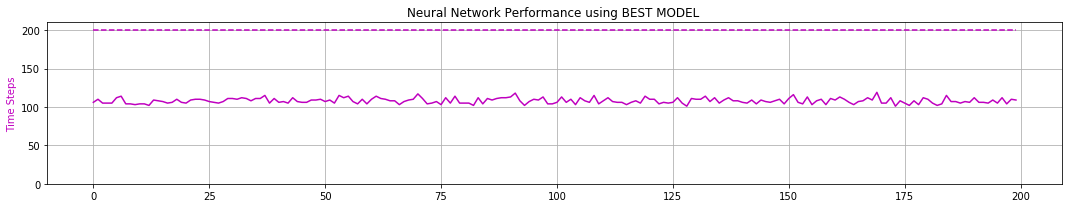

peak memory: 1473.11 MiB, increment: 1033.59 MiB
0 -max- [ 0.155  0.962  0.049  0.657]
0 -min- [-2.399 -2.904 -0.204 -1.382]

1 -max- [ 0.153  0.966  0.050  0.679]
1 -min- [-2.400 -2.938 -0.193 -1.446]

2 -max- [ 0.141  0.828  0.050  0.676]
2 -min- [-2.400 -2.951 -0.202 -1.179]

3 -max- [ 0.158  0.826  0.049  0.660]
3 -min- [-2.399 -2.940 -0.208 -1.219]

4 -max- [ 0.159  0.993  0.048  0.664]
4 -min- [-2.400 -2.940 -0.197 -1.364]

5 -max- [ 0.135  0.827  0.049  0.773]
5 -min- [-2.399 -2.936 -0.189 -1.257]

6 -max- [ 0.151  0.972  0.050  0.683]
6 -min- [-2.400 -2.928 -0.203 -1.363]

7 -max- [ 0.158  0.819  0.050  0.699]
7 -min- [-2.400 -2.944 -0.209 -1.186]

8 -max- [ 0.166  0.822  0.050  0.979]
8 -min- [-2.400 -3.100 -0.203 -1.190]

9 -max- [ 0.157  0.944  0.056  0.686]
9 -min- [-2.400 -2.931 -0.204 -1.361]

Quantization TIME:  0.01 minutes


ITERATION # 31
TOTAL EXPERIENCE GENERATED:   98848
SMALLEST TIMESTEP: 25
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   2999137
TOTAL PARALLEL T

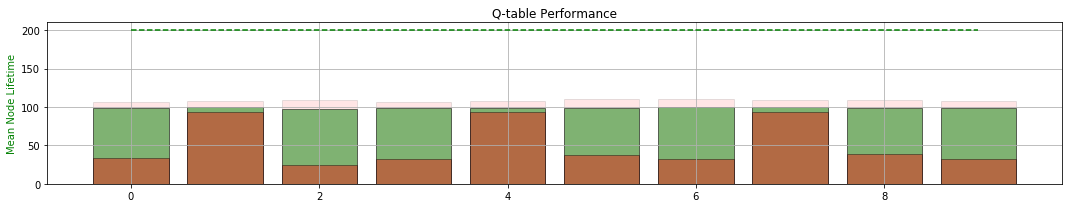

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 81.115	LOSS : 72.834	LOSS : 76.671	LOSS : 79.012	LOSS : 74.875	LOSS : 77.623	LOSS : 74.832	LOSS : 75.888	
Validating... MEAN TIME:  100.79
LOSS : 77.146	LOSS : 71.042	LOSS : 75.947	LOSS : 72.372	LOSS : 72.950	LOSS : 74.871	LOSS : 73.675	LOSS : 74.268	
Validating... MEAN TIME:  103.075
LOSS : 77.040	LOSS : 72.429	LOSS : 70.263	LOSS : 73.864	LOSS : 77.196	LOSS : 73.187	LOSS : 72.580	LOSS : 73.727	
Validating... MEAN TIME:  103.265
LOSS : 74.388	LOSS : 72.659	LOSS : 74.891	LOSS : 78.069	LOSS : 79.194	LOSS : 72.942	LOSS : 70.765	LOSS : 72.463	
Validating... MEAN TIME:  104.34
LOSS : 74.097	LOSS : 68.695	LOSS : 72.773	LOSS : 72.670	LOSS : 69.897	LOSS : 71.568	LOSS : 72.680	LOSS : 71.610	
Validating... MEAN TIME:  103.65
TRAINING TIME:0:00:56.792496


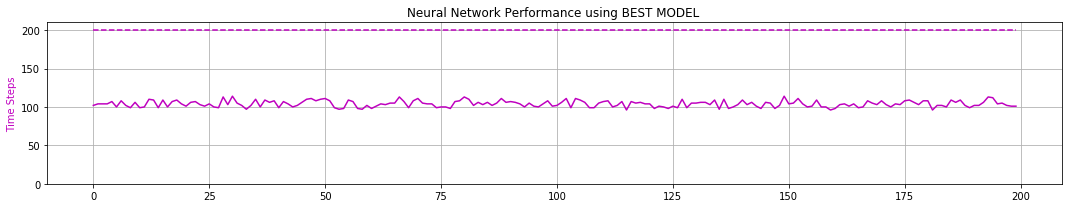

peak memory: 1468.07 MiB, increment: 971.06 MiB
0 -max- [ 0.161  1.019  0.050  0.780]
0 -min- [-2.400 -2.936 -0.204 -1.472]

1 -max- [ 0.158  0.828  0.050  0.777]
1 -min- [-2.398 -3.085 -0.209 -1.193]

2 -max- [ 0.160  0.828  0.049  0.780]
2 -min- [-2.400 -2.928 -0.209 -1.224]

3 -max- [ 0.153  0.991  0.054  0.701]
3 -min- [-2.400 -2.907 -0.206 -1.442]

4 -max- [ 0.146  0.827  0.049  0.693]
4 -min- [-2.400 -2.767 -0.209 -1.206]

5 -max- [ 0.151  0.946  0.050  0.690]
5 -min- [-2.395 -2.907 -0.206 -1.422]

6 -max- [ 0.160  1.001  0.050  0.881]
6 -min- [-2.400 -2.922 -0.205 -1.411]

7 -max- [ 0.168  0.822  0.050  0.694]
7 -min- [-2.400 -2.960 -0.205 -1.208]

8 -max- [ 0.173  0.944  0.050  0.692]
8 -min- [-2.400 -2.898 -0.208 -1.361]

9 -max- [ 0.143  1.019  0.048  0.683]
9 -min- [-2.400 -2.930 -0.207 -1.496]

Quantization TIME:  0.01 minutes


ITERATION # 32
TOTAL EXPERIENCE GENERATED:   97850
SMALLEST TIMESTEP: 16
LARGEST  TIMESTEP: 112
TOTAL SERIAL TIMESTEPS:   3096987
TOTAL PARALLEL TI

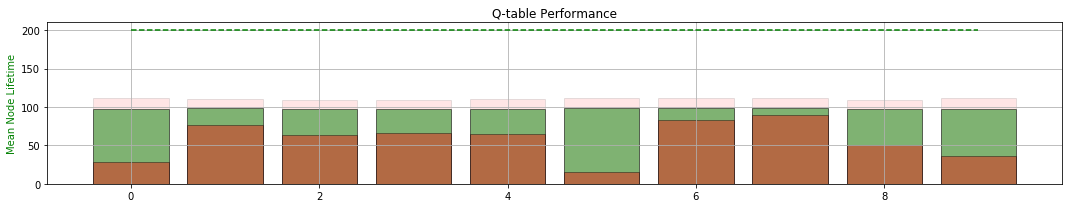

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 75.313	LOSS : 69.593	LOSS : 72.281	LOSS : 77.534	LOSS : 70.866	LOSS : 74.022	LOSS : 72.958	LOSS : 74.580	
Validating... MEAN TIME:  102.6
LOSS : 74.004	LOSS : 74.149	LOSS : 73.992	LOSS : 74.652	LOSS : 74.976	LOSS : 73.006	LOSS : 74.106	LOSS : 73.683	
Validating... MEAN TIME:  103.03
LOSS : 68.422	LOSS : 76.377	LOSS : 71.459	LOSS : 72.263	LOSS : 69.405	LOSS : 78.081	LOSS : 69.627	LOSS : 71.423	
Validating... MEAN TIME:  102.44
LOSS : 70.783	LOSS : 69.916	LOSS : 73.180	LOSS : 74.638	LOSS : 72.428	LOSS : 74.157	LOSS : 69.958	LOSS : 73.337	
Validating... MEAN TIME:  102.42
LOSS : 72.554	LOSS : 74.149	LOSS : 73.324	LOSS : 73.443	LOSS : 73.075	LOSS : 73.127	LOSS : 76.196	LOSS : 70.688	
Validating... MEAN TIME:  102.18
TRAINING TIME:0:00:56.595065


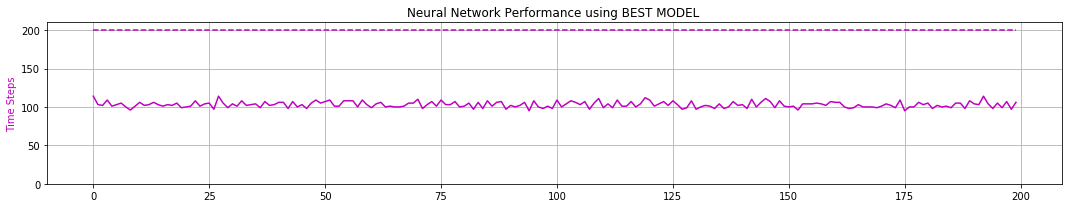

peak memory: 1444.71 MiB, increment: 1016.57 MiB
0 -max- [ 0.154  1.022  0.050  0.694]
0 -min- [-2.399 -3.167 -0.209 -1.348]

1 -max- [ 0.150  0.981  0.049  0.862]
1 -min- [-2.400 -3.169 -0.209 -1.457]

2 -max- [ 0.144  0.993  0.048  0.788]
2 -min- [-2.399 -3.160 -0.208 -1.490]

3 -max- [ 0.135  0.827  0.049  0.786]
3 -min- [-2.399 -3.169 -0.208 -1.206]

4 -max- [ 0.148  0.930  0.050  0.979]
4 -min- [-2.400 -3.339 -0.209 -1.357]

5 -max- [ 0.150  0.830  0.050  0.832]
5 -min- [-2.400 -3.163 -0.208 -1.186]

6 -max- [ 0.158  0.991  0.050  0.920]
6 -min- [-2.400 -3.277 -0.209 -1.438]

7 -max- [ 0.157  0.944  0.050  0.704]
7 -min- [-2.399 -3.168 -0.201 -1.361]

8 -max- [ 0.141  0.828  0.048  0.874]
8 -min- [-2.399 -3.353 -0.208 -1.282]

9 -max- [ 0.157  1.012  0.050  0.828]
9 -min- [-2.399 -3.156 -0.209 -1.440]

Quantization TIME:  0.01 minutes


ITERATION # 33
TOTAL EXPERIENCE GENERATED:   96568
SMALLEST TIMESTEP: 17
LARGEST  TIMESTEP: 111
TOTAL SERIAL TIMESTEPS:   3193555
TOTAL PARALLEL T

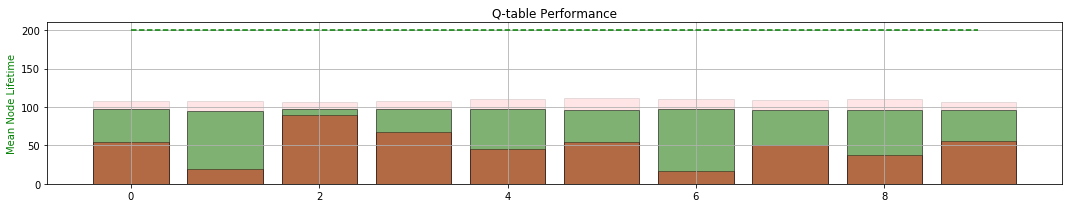

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 72.500	LOSS : 68.218	LOSS : 71.300	LOSS : 73.761	LOSS : 70.285	LOSS : 70.034	LOSS : 74.815	LOSS : 75.580	
Validating... MEAN TIME:  101.095
LOSS : 73.151	LOSS : 77.148	LOSS : 72.332	LOSS : 68.203	LOSS : 73.159	LOSS : 68.033	LOSS : 75.077	LOSS : 66.964	
Validating... MEAN TIME:  100.69
LOSS : 68.807	LOSS : 69.715	LOSS : 69.632	LOSS : 67.747	LOSS : 71.073	LOSS : 71.450	LOSS : 71.571	LOSS : 69.266	
Validating... MEAN TIME:  101.32
LOSS : 68.979	LOSS : 70.759	LOSS : 68.131	LOSS : 71.925	LOSS : 64.693	LOSS : 69.605	LOSS : 72.667	LOSS : 72.029	
Validating... MEAN TIME:  100.4
LOSS : 71.842	LOSS : 71.318	LOSS : 75.307	LOSS : 68.460	LOSS : 65.992	LOSS : 68.871	LOSS : 68.324	LOSS : 72.099	
Validating... MEAN TIME:  101.545
TRAINING TIME:0:00:57.514114


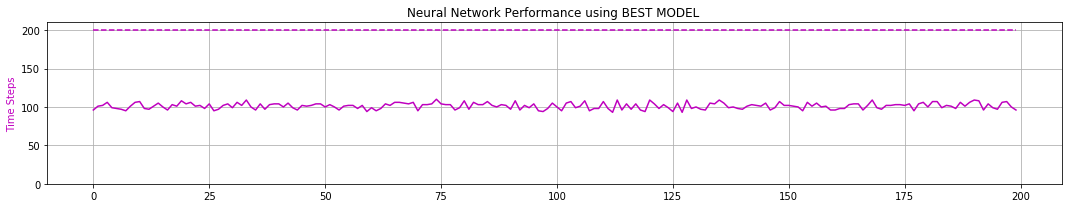

peak memory: 1432.30 MiB, increment: 1035.31 MiB
0 -max- [ 0.158  0.828  0.049  0.852]
0 -min- [-2.400 -3.292 -0.209 -1.191]

1 -max- [ 0.152  0.963  0.048  0.918]
1 -min- [-2.399 -3.251 -0.209 -1.453]

2 -max- [ 0.147  0.827  0.049  1.010]
2 -min- [-2.399 -3.165 -0.207 -1.206]

3 -max- [ 0.151  0.930  0.050  0.691]
3 -min- [-2.397 -3.167 -0.205 -1.357]

4 -max- [ 0.158  0.830  0.050  0.926]
4 -min- [-2.399 -3.356 -0.209 -1.201]

5 -max- [ 0.166  0.949  0.050  0.830]
5 -min- [-2.400 -3.339 -0.209 -1.440]

6 -max- [ 0.157  0.944  0.050  0.690]
6 -min- [-2.400 -3.157 -0.209 -1.361]

7 -max- [ 0.148  1.014  0.048  0.991]
7 -min- [-2.399 -3.337 -0.209 -1.433]

8 -max- [ 0.156  1.010  0.050  0.809]
8 -min- [-2.400 -3.348 -0.209 -1.468]

9 -max- [ 0.143  0.827  0.049  0.690]
9 -min- [-2.398 -3.170 -0.209 -1.195]

Quantization TIME:  0.01 minutes


ITERATION # 34
TOTAL EXPERIENCE GENERATED:   95806
SMALLEST TIMESTEP: 24
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   3289361
TOTAL PARALLEL T

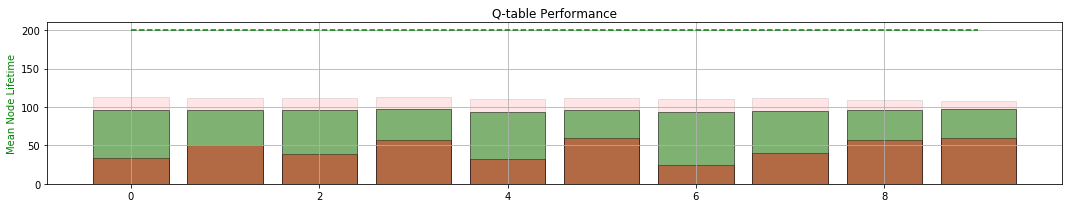

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 71.053	LOSS : 69.816	LOSS : 70.668	LOSS : 71.348	LOSS : 74.271	LOSS : 74.221	LOSS : 71.760	LOSS : 70.324	
Validating... MEAN TIME:  102.52
LOSS : 68.918	LOSS : 64.443	LOSS : 70.642	LOSS : 78.549	LOSS : 71.265	LOSS : 71.334	LOSS : 70.573	LOSS : 69.550	
Validating... MEAN TIME:  101.73
LOSS : 73.495	LOSS : 72.732	LOSS : 73.977	LOSS : 69.920	LOSS : 74.930	LOSS : 71.403	LOSS : 72.159	LOSS : 71.475	
Validating... MEAN TIME:  102.075
LOSS : 72.570	LOSS : 69.400	LOSS : 68.924	LOSS : 67.810	LOSS : 73.144	LOSS : 71.990	LOSS : 70.821	LOSS : 67.640	
Validating... MEAN TIME:  100.36
LOSS : 67.252	LOSS : 67.958	LOSS : 67.913	LOSS : 65.861	LOSS : 73.335	LOSS : 67.494	LOSS : 69.451	LOSS : 70.716	
Validating... MEAN TIME:  101.56
TRAINING TIME:0:00:57.485233


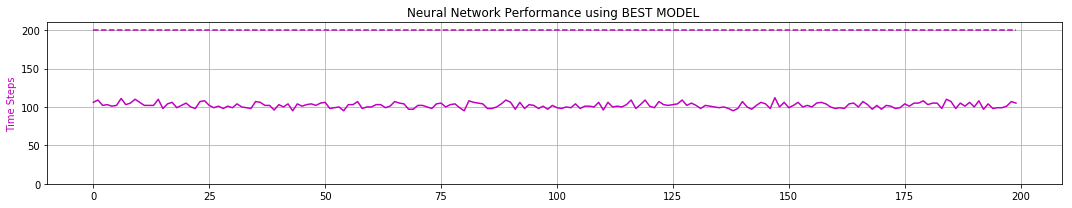

peak memory: 1433.49 MiB, increment: 977.78 MiB
0 -max- [ 0.144  0.991  0.054  0.772]
0 -min- [-2.400 -3.319 -0.209 -1.467]

1 -max- [ 0.133  0.827  0.049  0.822]
1 -min- [-2.400 -3.171 -0.209 -1.206]

2 -max- [ 0.145  0.993  0.050  0.900]
2 -min- [-2.400 -3.332 -0.209 -1.442]

3 -max- [ 0.148  0.830  0.050  0.898]
3 -min- [-2.400 -3.277 -0.209 -1.212]

4 -max- [ 0.156  0.822  0.050  0.836]
4 -min- [-2.400 -3.243 -0.209 -1.218]

5 -max- [ 0.155  1.013  0.050  0.890]
5 -min- [-2.399 -3.341 -0.209 -1.479]

6 -max- [ 0.132  0.828  0.048  0.739]
6 -min- [-2.399 -3.305 -0.209 -1.201]

7 -max- [ 0.137  0.931  0.050  0.754]
7 -min- [-2.398 -3.250 -0.209 -1.439]

8 -max- [ 0.131  0.827  0.049  0.887]
8 -min- [-2.399 -3.317 -0.209 -1.195]

9 -max- [ 0.152  1.013  0.050  0.761]
9 -min- [-2.400 -3.254 -0.206 -1.469]

Quantization TIME:  0.01 minutes


ITERATION # 35
TOTAL EXPERIENCE GENERATED:   97080
SMALLEST TIMESTEP: 30
LARGEST  TIMESTEP: 115
TOTAL SERIAL TIMESTEPS:   3386441
TOTAL PARALLEL TI

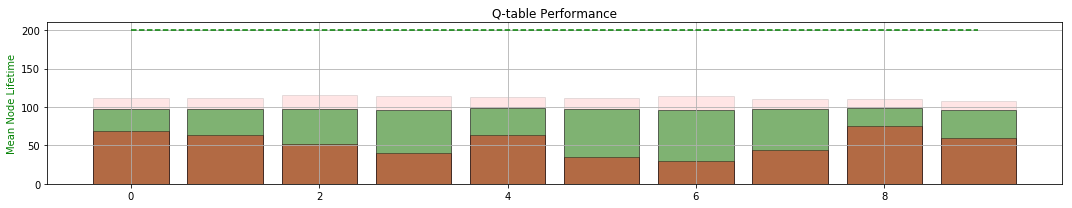

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 65.628	LOSS : 66.647	LOSS : 71.550	LOSS : 69.019	LOSS : 72.639	LOSS : 68.040	LOSS : 67.061	LOSS : 67.605	
Validating... MEAN TIME:  102.525
LOSS : 69.261	LOSS : 67.785	LOSS : 69.795	LOSS : 68.460	LOSS : 65.198	LOSS : 68.511	LOSS : 66.886	LOSS : 66.659	
Validating... MEAN TIME:  102.49
LOSS : 68.248	LOSS : 70.588	LOSS : 65.663	LOSS : 70.022	LOSS : 68.506	LOSS : 62.255	LOSS : 66.053	LOSS : 70.105	
Validating... MEAN TIME:  101.645
LOSS : 67.141	LOSS : 66.721	LOSS : 67.253	LOSS : 67.805	LOSS : 69.480	LOSS : 64.382	LOSS : 68.572	LOSS : 66.574	
Validating... MEAN TIME:  102.71
LOSS : 68.115	LOSS : 69.919	LOSS : 66.944	LOSS : 70.566	LOSS : 68.046	LOSS : 70.266	LOSS : 66.720	LOSS : 68.867	
Validating... MEAN TIME:  102.385
TRAINING TIME:0:00:57.183641


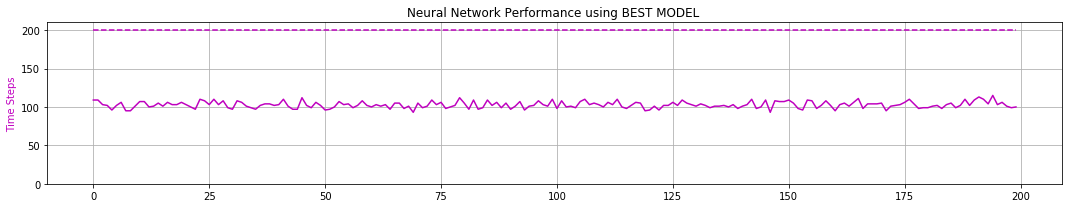

peak memory: 1447.08 MiB, increment: 1011.43 MiB
0 -max- [ 0.128  0.827  0.049  1.084]
0 -min- [-2.399 -3.190 -0.207 -1.257]

1 -max- [ 0.137  0.820  0.050  0.687]
1 -min- [-2.399 -3.306 -0.209 -1.264]

2 -max- [ 0.142  0.819  0.050  0.685]
2 -min- [-2.400 -3.170 -0.209 -1.186]

3 -max- [ 0.150  0.986  0.050  0.764]
3 -min- [-2.400 -3.338 -0.209 -1.403]

4 -max- [ 0.149  0.823  0.050  0.750]
4 -min- [-2.399 -3.169 -0.205 -1.183]

5 -max- [ 0.132  0.828  0.048  0.883]
5 -min- [-2.400 -3.171 -0.206 -1.219]

6 -max- [ 0.133  0.943  0.050  0.810]
6 -min- [-2.400 -3.339 -0.209 -1.440]

7 -max- [ 0.127  0.827  0.049  0.882]
7 -min- [-2.400 -3.306 -0.209 -1.186]

8 -max- [ 0.147  0.827  0.050  0.788]
8 -min- [-2.400 -3.255 -0.209 -1.194]

9 -max- [ 0.116  0.831  0.049  0.716]
9 -min- [-2.398 -3.246 -0.208 -1.232]

Quantization TIME:  0.01 minutes


ITERATION # 36
TOTAL EXPERIENCE GENERATED:   76953
SMALLEST TIMESTEP: 31
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   3463394
TOTAL PARALLEL T

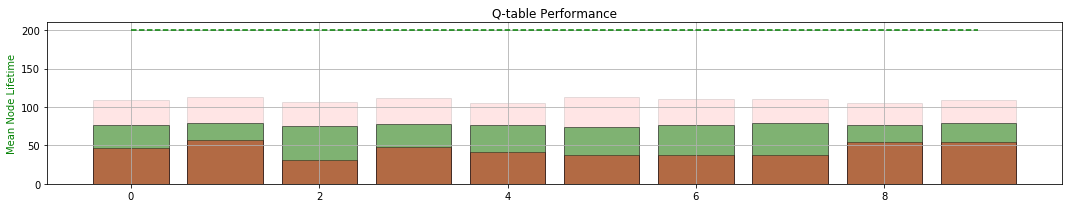

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 87.886	LOSS : 83.084	LOSS : 89.817	LOSS : 91.434	LOSS : 85.403	LOSS : 86.809	LOSS : 90.288	LOSS : 86.523	
Validating... MEAN TIME:  120.3
LOSS : 94.036	LOSS : 90.711	LOSS : 91.868	LOSS : 90.568	LOSS : 88.358	LOSS : 95.324	LOSS : 91.690	LOSS : 85.336	
Validating... MEAN TIME:  123.49
LOSS : 99.265	LOSS : 90.170	LOSS : 83.137	LOSS : 85.999	LOSS : 85.787	LOSS : 90.043	LOSS : 90.258	LOSS : 87.690	
Validating... MEAN TIME:  122.67
LOSS : 90.434	LOSS : 94.293	LOSS : 88.514	LOSS : 88.619	LOSS : 88.520	LOSS : 88.455	LOSS : 85.818	LOSS : 88.544	
Validating... MEAN TIME:  119.68
LOSS : 92.652	LOSS : 89.979	LOSS : 91.137	LOSS : 90.568	LOSS : 93.369	LOSS : 91.965	LOSS : 88.158	LOSS : 91.514	
Validating... MEAN TIME:  122.495
TRAINING TIME:0:01:01.114280


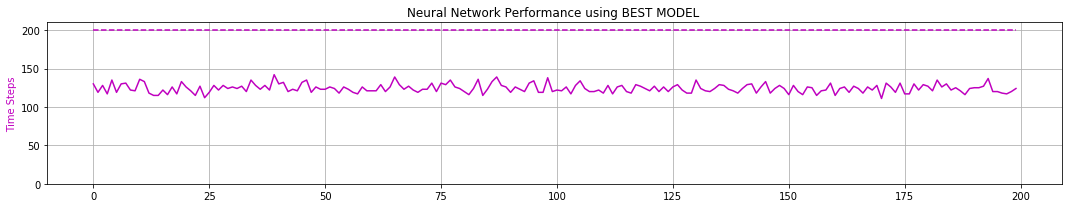

peak memory: 1416.11 MiB, increment: 1035.53 MiB
0 -max- [ 0.135  0.807  0.050  0.678]
0 -min- [-2.383 -3.284 -0.209 -1.172]

1 -max- [ 0.144  0.829  0.050  0.669]
1 -min- [-2.397 -3.293 -0.209 -1.226]

2 -max- [ 0.150  0.986  0.050  0.762]
2 -min- [-2.396 -3.302 -0.209 -1.403]

3 -max- [ 0.151  0.823  0.050  0.644]
3 -min- [-2.394 -3.274 -0.209 -1.205]

4 -max- [ 0.126  0.820  0.048  0.689]
4 -min- [-2.397 -3.278 -0.209 -1.183]

5 -max- [ 0.140  0.963  0.050  0.640]
5 -min- [-2.400 -3.269 -0.209 -1.425]

6 -max- [ 0.127  0.827  0.049  0.633]
6 -min- [-2.390 -3.163 -0.209 -1.186]

7 -max- [ 0.147  0.826  0.050  0.614]
7 -min- [-2.397 -3.270 -0.209 -1.194]

8 -max- [ 0.118  0.938  0.049  0.610]
8 -min- [-2.391 -3.272 -0.209 -1.402]

9 -max- [ 0.147  0.827  0.049  0.592]
9 -min- [-2.397 -3.286 -0.209 -1.183]

Quantization TIME:  0.01 minutes


ITERATION # 37
TOTAL EXPERIENCE GENERATED:   114113
SMALLEST TIMESTEP: 92
LARGEST  TIMESTEP: 140
TOTAL SERIAL TIMESTEPS:   3577507
TOTAL PARALLEL 

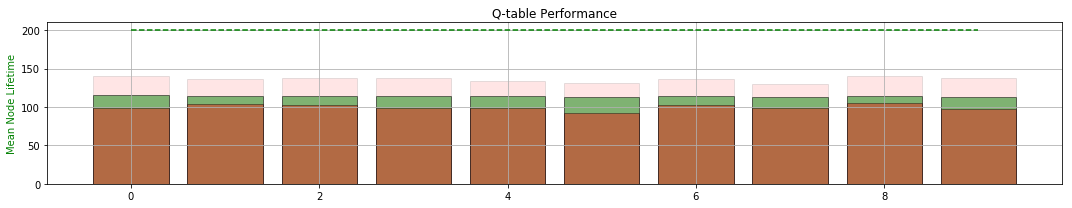

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 84.667	LOSS : 80.093	LOSS : 81.211	LOSS : 86.236	LOSS : 83.795	LOSS : 81.074	LOSS : 79.028	LOSS : 86.684	
Validating... MEAN TIME:  115.95
LOSS : 88.072	LOSS : 81.505	LOSS : 80.478	LOSS : 80.773	LOSS : 85.747	LOSS : 80.540	LOSS : 86.671	LOSS : 83.657	
Validating... MEAN TIME:  115.465
LOSS : 83.327	LOSS : 82.183	LOSS : 82.454	LOSS : 85.100	LOSS : 80.493	LOSS : 86.661	LOSS : 79.047	LOSS : 85.438	
Validating... MEAN TIME:  113.06
LOSS : 83.160	LOSS : 77.010	LOSS : 81.554	LOSS : 80.149	LOSS : 77.127	LOSS : 84.257	LOSS : 81.426	LOSS : 81.113	
Validating... MEAN TIME:  113.52
LOSS : 86.241	LOSS : 83.470	LOSS : 83.168	LOSS : 80.348	LOSS : 84.744	LOSS : 77.796	LOSS : 76.929	LOSS : 77.695	
Validating... MEAN TIME:  111.695
TRAINING TIME:0:00:59.544453


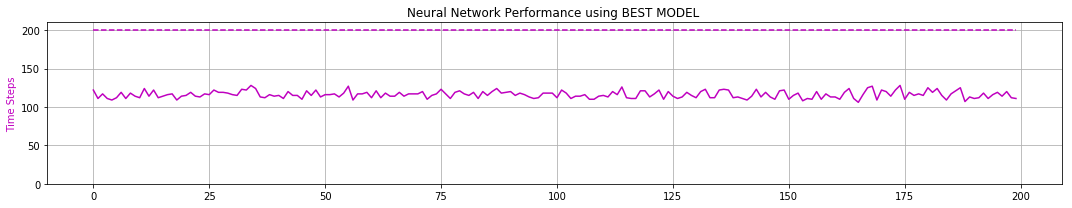

peak memory: 1402.37 MiB, increment: 963.09 MiB
0 -max- [ 0.122  0.819  0.050  0.909]
0 -min- [-2.400 -3.098 -0.209 -1.156]

1 -max- [ 0.129  0.995  0.050  0.930]
1 -min- [-2.400 -3.114 -0.209 -1.446]

2 -max- [ 0.125  0.821  0.050  0.977]
2 -min- [-2.400 -2.975 -0.209 -1.224]

3 -max- [ 0.111  0.820  0.048  0.891]
3 -min- [-2.400 -2.965 -0.208 -1.204]

4 -max- [ 0.121  1.019  0.050  0.900]
4 -min- [-2.399 -2.952 -0.209 -1.389]

5 -max- [ 0.113  0.929  0.053  0.929]
5 -min- [-2.400 -2.947 -0.209 -1.434]

6 -max- [ 0.123  0.826  0.050  0.887]
6 -min- [-2.400 -3.158 -0.208 -1.168]

7 -max- [ 0.094  0.825  0.049  0.874]
7 -min- [-2.400 -2.970 -0.206 -1.166]

8 -max- [ 0.123  0.826  0.049  0.882]
8 -min- [-2.400 -2.949 -0.208 -1.145]

9 -max- [ 0.124  0.942  0.053  0.943]
9 -min- [-2.400 -3.127 -0.209 -1.355]

Quantization TIME:  0.01 minutes


ITERATION # 38
TOTAL EXPERIENCE GENERATED:   102800
SMALLEST TIMESTEP: 54
LARGEST  TIMESTEP: 119
TOTAL SERIAL TIMESTEPS:   3680307
TOTAL PARALLEL T

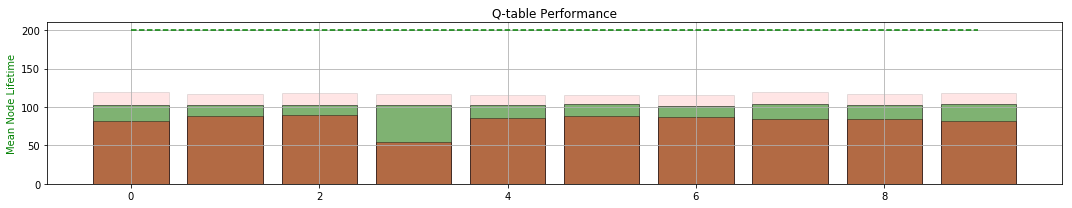

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 69.431	LOSS : 63.871	LOSS : 70.141	LOSS : 69.874	LOSS : 69.216	LOSS : 70.618	LOSS : 64.958	LOSS : 67.653	
Validating... MEAN TIME:  110.095
LOSS : 73.325	LOSS : 66.629	LOSS : 67.985	LOSS : 67.159	LOSS : 64.770	LOSS : 68.853	LOSS : 70.136	LOSS : 72.530	
Validating... MEAN TIME:  110.245
LOSS : 63.727	LOSS : 67.500	LOSS : 68.792	LOSS : 69.846	LOSS : 63.390	LOSS : 70.169	LOSS : 67.844	LOSS : 69.795	
Validating... MEAN TIME:  110.575
LOSS : 67.976	LOSS : 67.227	LOSS : 67.278	LOSS : 67.032	LOSS : 68.397	LOSS : 68.569	LOSS : 63.453	LOSS : 66.431	
Validating... MEAN TIME:  112.355
LOSS : 67.474	LOSS : 67.260	LOSS : 68.956	LOSS : 64.287	LOSS : 66.097	LOSS : 67.291	LOSS : 67.545	LOSS : 68.554	
Validating... MEAN TIME:  113.805
TRAINING TIME:0:00:58.721273


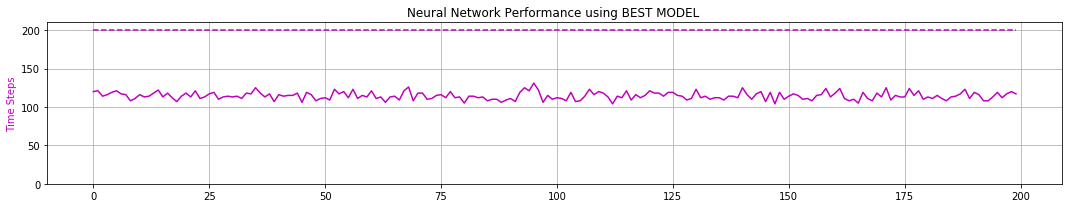

peak memory: 1470.39 MiB, increment: 973.96 MiB
0 -max- [ 0.166  0.972  0.050  0.909]
0 -min- [-2.399 -2.946 -0.209 -1.436]

1 -max- [ 0.157  0.944  0.050  0.874]
1 -min- [-2.400 -2.953 -0.209 -1.361]

2 -max- [ 0.134  0.820  0.048  0.850]
2 -min- [-2.400 -2.945 -0.209 -1.195]

3 -max- [ 0.138  1.012  0.051  0.892]
3 -min- [-2.398 -2.961 -0.209 -1.385]

4 -max- [ 0.135  0.992  0.049  0.888]
4 -min- [-2.400 -2.955 -0.209 -1.367]

5 -max- [ 0.144  1.013  0.050  0.838]
5 -min- [-2.397 -2.942 -0.209 -1.364]

6 -max- [ 0.115  0.829  0.049  0.858]
6 -min- [-2.399 -2.956 -0.209 -1.231]

7 -max- [ 0.155  0.827  0.049  0.890]
7 -min- [-2.399 -2.935 -0.209 -1.225]

8 -max- [ 0.154  0.938  0.048  0.926]
8 -min- [-2.399 -3.083 -0.209 -1.363]

9 -max- [ 0.159  1.014  0.051  0.898]
9 -min- [-2.398 -2.944 -0.209 -1.361]

Quantization TIME:  0.01 minutes


ITERATION # 39
TOTAL EXPERIENCE GENERATED:   105636
SMALLEST TIMESTEP: 63
LARGEST  TIMESTEP: 126
TOTAL SERIAL TIMESTEPS:   3785943
TOTAL PARALLEL T

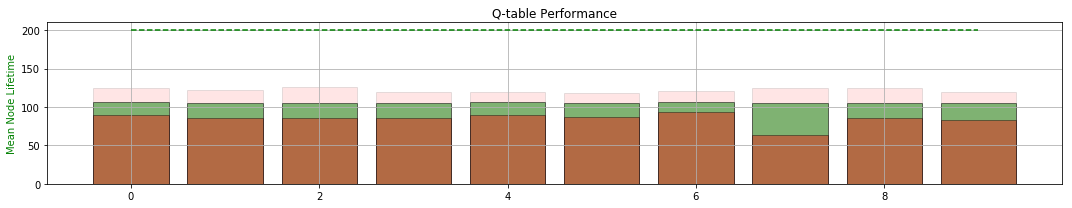

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 66.712	LOSS : 69.241	LOSS : 71.014	LOSS : 71.714	LOSS : 75.072	LOSS : 70.125	LOSS : 72.973	LOSS : 72.535	
Validating... MEAN TIME:  108.435
LOSS : 70.231	LOSS : 72.118	LOSS : 66.062	LOSS : 66.917	LOSS : 69.170	LOSS : 74.192	LOSS : 70.487	LOSS : 70.355	
Validating... MEAN TIME:  108.815
LOSS : 70.734	LOSS : 68.990	LOSS : 69.660	LOSS : 69.309	LOSS : 68.303	LOSS : 71.787	LOSS : 68.518	LOSS : 68.318	
Validating... MEAN TIME:  109.505
LOSS : 68.653	LOSS : 68.277	LOSS : 65.123	LOSS : 69.290	LOSS : 65.173	LOSS : 66.787	LOSS : 71.184	LOSS : 69.065	
Validating... MEAN TIME:  109.315
LOSS : 69.268	LOSS : 69.694	LOSS : 72.956	LOSS : 71.313	LOSS : 66.509	LOSS : 66.780	LOSS : 67.184	LOSS : 70.685	
Validating... MEAN TIME:  109.68
TRAINING TIME:0:00:58.996636


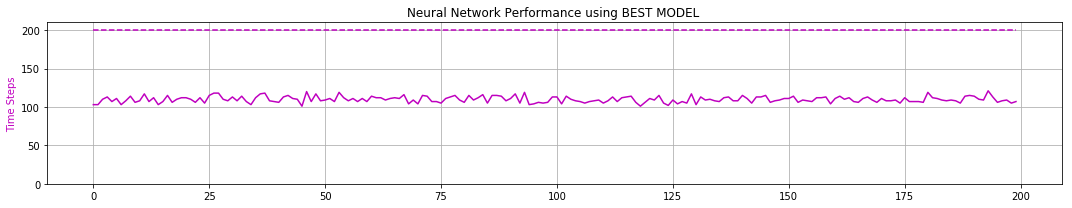

peak memory: 1495.40 MiB, increment: 978.76 MiB
0 -max- [ 0.141  0.823  0.050  0.633]
0 -min- [-2.400 -3.162 -0.209 -1.212]

1 -max- [ 0.121  0.820  0.048  0.698]
1 -min- [-2.399 -3.153 -0.209 -1.183]

2 -max- [ 0.125  0.824  0.050  0.862]
2 -min- [-2.399 -3.158 -0.209 -1.214]

3 -max- [ 0.148  0.939  0.049  0.857]
3 -min- [-2.400 -3.147 -0.209 -1.389]

4 -max- [ 0.139  0.826  0.050  0.693]
4 -min- [-2.399 -3.163 -0.209 -1.194]

5 -max- [ 0.101  0.829  0.049  0.678]
5 -min- [-2.400 -3.162 -0.209 -1.194]

6 -max- [ 0.135  0.827  0.049  0.781]
6 -min- [-2.400 -3.144 -0.209 -1.183]

7 -max- [ 0.142  0.823  0.047  0.888]
7 -min- [-2.399 -3.165 -0.209 -1.182]

8 -max- [ 0.144  0.827  0.051  0.789]
8 -min- [-2.400 -3.149 -0.209 -1.179]

9 -max- [ 0.142  0.827  0.047  0.698]
9 -min- [-2.400 -3.162 -0.209 -1.191]

Quantization TIME:  0.01 minutes


ITERATION # 40
TOTAL EXPERIENCE GENERATED:   103558
SMALLEST TIMESTEP: 29
LARGEST  TIMESTEP: 124
TOTAL SERIAL TIMESTEPS:   3889501
TOTAL PARALLEL T

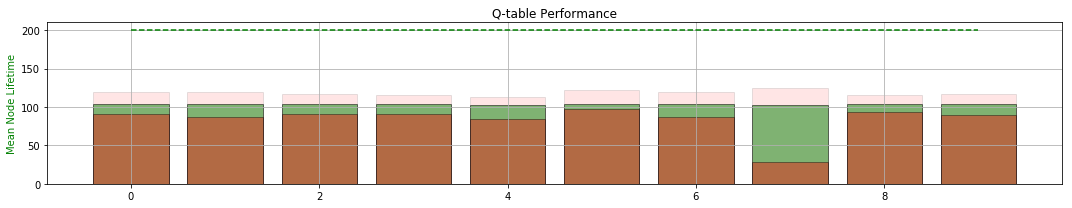

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 64.450	LOSS : 67.123	LOSS : 71.891	LOSS : 64.830	LOSS : 66.449	LOSS : 64.910	LOSS : 64.511	LOSS : 63.517	
Validating... MEAN TIME:  109.905
LOSS : 65.936	LOSS : 62.806	LOSS : 63.406	LOSS : 64.872	LOSS : 63.048	LOSS : 63.050	LOSS : 62.683	LOSS : 64.251	
Validating... MEAN TIME:  113.675
LOSS : 63.208	LOSS : 62.326	LOSS : 64.537	LOSS : 62.589	LOSS : 65.072	LOSS : 59.635	LOSS : 62.156	LOSS : 58.396	
Validating... MEAN TIME:  112.74
LOSS : 65.415	LOSS : 61.796	LOSS : 62.908	LOSS : 61.989	LOSS : 60.423	LOSS : 64.107	LOSS : 61.094	LOSS : 59.082	
Validating... MEAN TIME:  111.155
LOSS : 62.235	LOSS : 63.118	LOSS : 59.437	LOSS : 65.698	LOSS : 57.399	LOSS : 58.913	LOSS : 67.053	LOSS : 64.479	
Validating... MEAN TIME:  110.67
TRAINING TIME:0:01:04.220907


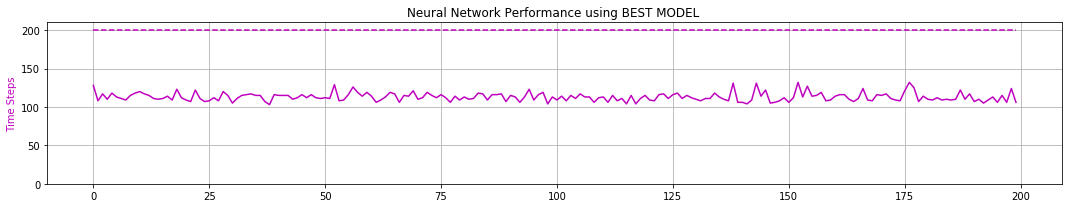

peak memory: 1486.73 MiB, increment: 1032.89 MiB
0 -max- [ 0.131  0.979  0.053  0.859]
0 -min- [-2.399 -3.167 -0.204 -1.323]

1 -max- [ 0.133  0.934  0.050  0.667]
1 -min- [-2.398 -3.163 -0.208 -1.401]

2 -max- [ 0.123  0.929  0.049  0.814]
2 -min- [-2.400 -3.168 -0.203 -1.434]

3 -max- [ 0.144  0.826  0.050  0.690]
3 -min- [-2.400 -3.171 -0.209 -1.257]

4 -max- [ 0.107  0.828  0.049  0.877]
4 -min- [-2.398 -3.166 -0.209 -1.194]

5 -max- [ 0.139  0.827  0.049  0.856]
5 -min- [-2.400 -3.355 -0.208 -1.221]

6 -max- [ 0.150  0.822  0.047  0.686]
6 -min- [-2.400 -3.168 -0.206 -1.175]

7 -max- [ 0.148  0.827  0.051  0.849]
7 -min- [-2.399 -3.168 -0.208 -1.201]

8 -max- [ 0.138  0.982  0.047  0.673]
8 -min- [-2.399 -3.165 -0.206 -1.414]

9 -max- [ 0.133  0.980  0.056  0.747]
9 -min- [-2.399 -3.166 -0.206 -1.321]

Quantization TIME:  0.01 minutes


ITERATION # 41
TOTAL EXPERIENCE GENERATED:   97767
SMALLEST TIMESTEP: 57
LARGEST  TIMESTEP: 152
TOTAL SERIAL TIMESTEPS:   3987268
TOTAL PARALLEL T

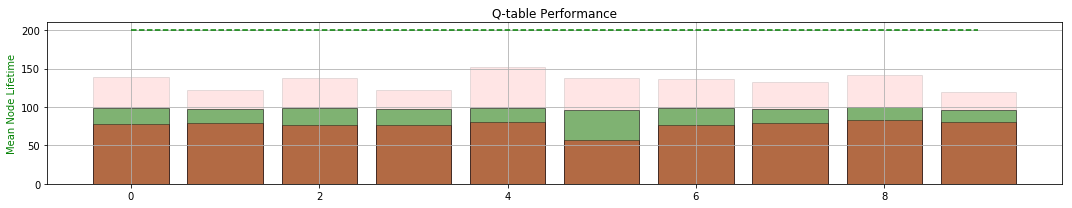

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 73.940	LOSS : 70.429	LOSS : 73.089	LOSS : 76.861	LOSS : 73.537	LOSS : 74.881	LOSS : 73.238	LOSS : 76.845	
Validating... MEAN TIME:  118.05
LOSS : 70.694	LOSS : 74.331	LOSS : 81.267	LOSS : 76.986	LOSS : 76.856	LOSS : 75.608	LOSS : 71.735	LOSS : 75.075	
Validating... MEAN TIME:  129.425
LOSS : 80.106	LOSS : 80.233	LOSS : 72.181	LOSS : 77.394	LOSS : 74.321	LOSS : 76.712	LOSS : 74.971	LOSS : 80.784	
Validating... MEAN TIME:  136.465
LOSS : 78.453	LOSS : 79.719	LOSS : 72.928	LOSS : 78.254	LOSS : 77.195	LOSS : 75.829	LOSS : 79.702	LOSS : 77.866	
Validating... MEAN TIME:  147.88
LOSS : 83.598	LOSS : 79.352	LOSS : 86.930	LOSS : 77.576	LOSS : 76.907	LOSS : 78.407	LOSS : 74.633	LOSS : 78.215	
Validating... MEAN TIME:  139.53
TRAINING TIME:0:01:07.099572


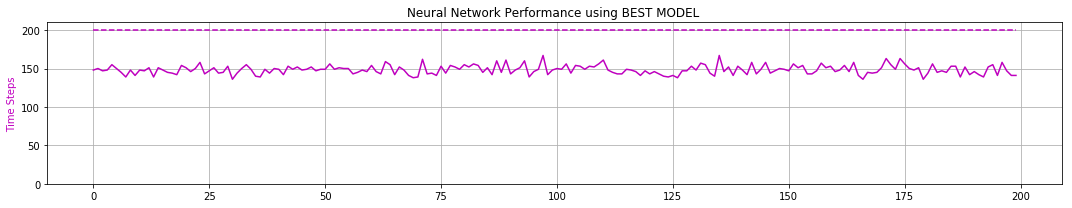

peak memory: 1488.82 MiB, increment: 978.55 MiB
0 -max- [ 0.108  0.748  0.050  0.884]
0 -min- [-2.396 -2.970 -0.209 -1.131]

1 -max- [ 0.099  0.633  0.049  0.623]
1 -min- [-2.392 -3.146 -0.209 -0.933]

2 -max- [ 0.118  0.823  0.050  0.749]
2 -min- [-2.398 -3.083 -0.209 -1.179]

3 -max- [ 0.084  0.634  0.049  0.685]
3 -min- [-2.397 -2.973 -0.209 -0.923]

4 -max- [ 0.147  0.762  0.049  0.796]
4 -min- [-2.395 -3.150 -0.209 -1.202]

5 -max- [ 0.120  0.763  0.047  0.829]
5 -min- [-2.398 -2.961 -0.209 -1.159]

6 -max- [ 0.126  0.776  0.051  0.812]
6 -min- [-2.397 -3.141 -0.209 -1.076]

7 -max- [ 0.112  0.787  0.047  0.649]
7 -min- [-2.400 -2.974 -0.209 -1.119]

8 -max- [ 0.113  0.633  0.050  0.684]
8 -min- [-2.385 -2.967 -0.209 -0.993]

9 -max- [ 0.111  0.780  0.050  0.808]
9 -min- [-2.395 -3.147 -0.209 -1.227]

Quantization TIME:  0.01 minutes


ITERATION # 42
TOTAL EXPERIENCE GENERATED:   138019
SMALLEST TIMESTEP: 75
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4125287
TOTAL PARALLEL T

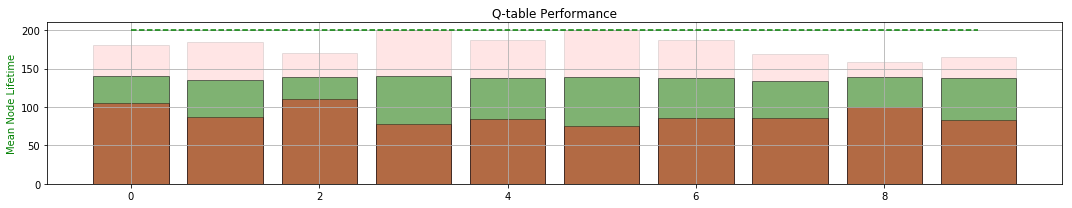

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 79.853	LOSS : 74.241	LOSS : 74.425	LOSS : 73.140	LOSS : 74.284	LOSS : 75.497	LOSS : 73.519	LOSS : 72.217	
Validating... MEAN TIME:  132.895
LOSS : 70.032	LOSS : 68.439	LOSS : 69.240	LOSS : 65.506	LOSS : 71.399	LOSS : 67.674	LOSS : 71.609	LOSS : 68.583	
Validating... MEAN TIME:  128.845
LOSS : 69.743	LOSS : 69.773	LOSS : 67.509	LOSS : 67.553	LOSS : 68.641	LOSS : 65.629	LOSS : 68.994	LOSS : 67.008	
Validating... MEAN TIME:  122.98
LOSS : 63.941	LOSS : 69.257	LOSS : 67.982	LOSS : 65.416	LOSS : 66.205	LOSS : 67.229	LOSS : 66.384	LOSS : 66.219	
Validating... MEAN TIME:  128.87
LOSS : 66.333	LOSS : 61.665	LOSS : 64.377	LOSS : 64.952	LOSS : 67.537	LOSS : 61.548	LOSS : 67.699	LOSS : 66.072	
Validating... MEAN TIME:  130.905
TRAINING TIME:0:01:07.510602


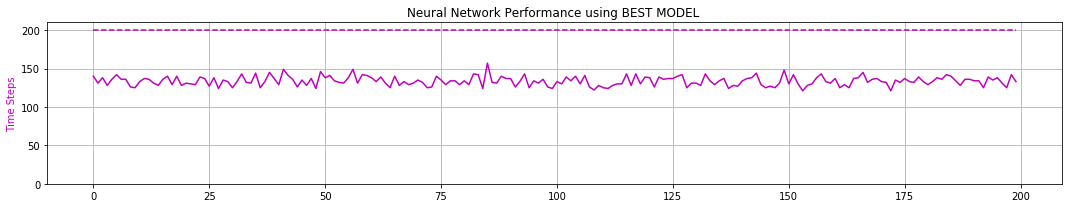

peak memory: 1481.97 MiB, increment: 1061.50 MiB
0 -max- [ 0.516  1.098  0.209  0.736]
0 -min- [-2.400 -2.429 -0.203 -1.088]

1 -max- [ 0.506  1.141  0.209  0.830]
1 -min- [-2.399 -2.425 -0.204 -1.110]

2 -max- [ 0.502  1.091  0.208  0.831]
2 -min- [-2.399 -2.510 -0.209 -0.900]

3 -max- [ 0.502  1.095  0.208  0.768]
3 -min- [-2.400 -2.419 -0.194 -1.112]

4 -max- [ 0.503  1.118  0.209  0.913]
4 -min- [-2.400 -2.417 -0.203 -1.080]

5 -max- [ 0.505  1.114  0.206  0.894]
5 -min- [-2.400 -2.431 -0.202 -1.094]

6 -max- [ 0.504  1.077  0.209  0.881]
6 -min- [-2.400 -2.426 -0.200 -0.888]

7 -max- [ 0.518  1.111  0.209  0.835]
7 -min- [-2.400 -2.571 -0.207 -1.098]

8 -max- [ 0.500  1.125  0.208  0.801]
8 -min- [-2.400 -2.587 -0.195 -1.079]

9 -max- [ 0.524  1.133  0.208  0.992]
9 -min- [-2.400 -2.418 -0.208 -1.129]

Quantization TIME:  0.01 minutes


ITERATION # 43
TOTAL EXPERIENCE GENERATED:   124943
SMALLEST TIMESTEP: 94
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4250230
TOTAL PARALLEL 

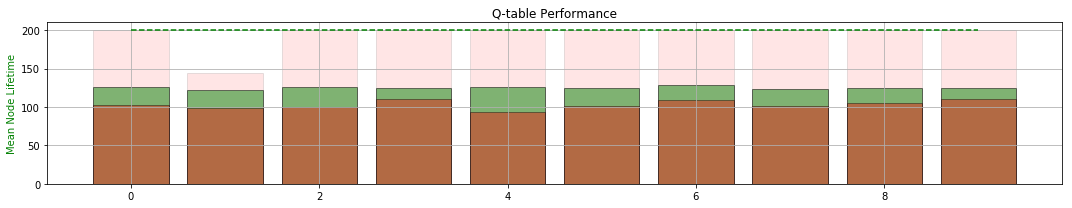

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 59.407	LOSS : 63.210	LOSS : 57.082	LOSS : 60.287	LOSS : 61.596	LOSS : 56.292	LOSS : 60.583	LOSS : 55.287	
Validating... MEAN TIME:  135.48
LOSS : 57.807	LOSS : 59.038	LOSS : 56.028	LOSS : 54.782	LOSS : 57.087	LOSS : 58.395	LOSS : 57.480	LOSS : 53.694	
Validating... MEAN TIME:  132.395
LOSS : 57.171	LOSS : 55.964	LOSS : 56.601	LOSS : 58.550	LOSS : 60.395	LOSS : 58.550	LOSS : 58.340	LOSS : 56.495	
Validating... MEAN TIME:  130.02
LOSS : 58.043	LOSS : 55.441	LOSS : 57.103	LOSS : 60.297	LOSS : 60.687	LOSS : 60.120	LOSS : 54.147	LOSS : 59.097	
Validating... MEAN TIME:  135.02
LOSS : 57.811	LOSS : 60.538	LOSS : 55.635	LOSS : 51.644	LOSS : 57.404	LOSS : 54.645	LOSS : 51.910	LOSS : 55.817	
Validating... MEAN TIME:  135.855
TRAINING TIME:0:01:07.661537


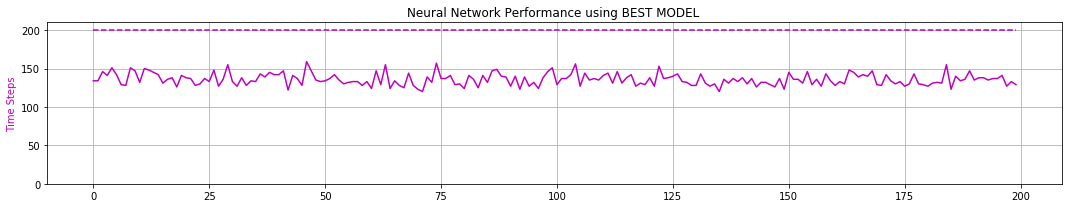

peak memory: 1472.18 MiB, increment: 994.90 MiB
0 -max- [ 0.111  0.632  0.050  0.687]
0 -min- [-2.398 -2.769 -0.209 -0.968]

1 -max- [ 0.079  0.634  0.049  0.898]
1 -min- [-2.400 -2.702 -0.209 -1.111]

2 -max- [ 0.667  1.291  0.203  0.772]
2 -min- [-2.399 -2.748 -0.209 -0.895]

3 -max- [ 0.184  0.628  0.047  0.826]
3 -min- [-2.398 -2.604 -0.209 -1.098]

4 -max- [ 0.663  1.141  0.209  0.867]
4 -min- [-2.400 -2.755 -0.209 -1.098]

5 -max- [ 0.122  0.633  0.055  0.837]
5 -min- [-2.399 -2.599 -0.209 -1.099]

6 -max- [ 0.113  0.762  0.050  0.650]
6 -min- [-2.392 -2.700 -0.209 -1.146]

7 -max- [ 0.090  0.633  0.053  0.656]
7 -min- [-2.399 -2.592 -0.209 -1.079]

8 -max- [ 0.142  0.795  0.050  0.993]
8 -min- [-2.398 -2.603 -0.209 -1.392]

9 -max- [ 0.152  0.633  0.049  0.740]
9 -min- [-2.399 -2.707 -0.209 -0.893]

Quantization TIME:  0.01 minutes


ITERATION # 44
TOTAL EXPERIENCE GENERATED:   159544
SMALLEST TIMESTEP: 63
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4409774
TOTAL PARALLEL T

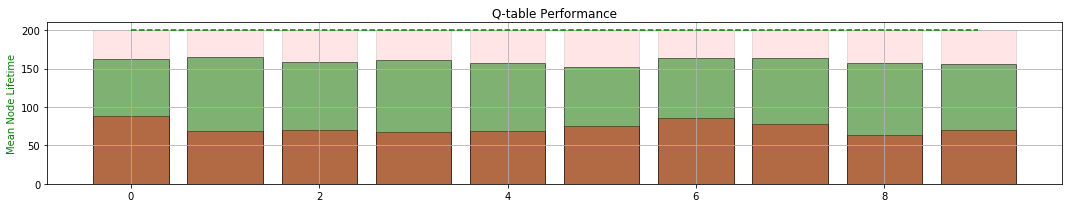

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 54.356	LOSS : 53.188	LOSS : 50.401	LOSS : 49.541	LOSS : 54.043	LOSS : 51.218	LOSS : 52.271	LOSS : 50.455	
Validating... MEAN TIME:  149.57
LOSS : 46.479	LOSS : 51.150	LOSS : 50.380	LOSS : 51.422	LOSS : 50.638	LOSS : 51.861	LOSS : 52.652	LOSS : 49.319	
Validating... MEAN TIME:  137.195
LOSS : 55.674	LOSS : 50.542	LOSS : 53.701	LOSS : 49.771	LOSS : 51.566	LOSS : 49.311	LOSS : 51.442	LOSS : 51.125	
Validating... MEAN TIME:  145.78
LOSS : 48.979	LOSS : 52.277	LOSS : 53.505	LOSS : 48.436	LOSS : 49.510	LOSS : 48.756	LOSS : 48.602	LOSS : 51.901	
Validating... MEAN TIME:  153.185
LOSS : 53.324	LOSS : 47.734	LOSS : 51.887	LOSS : 47.506	LOSS : 50.313	LOSS : 49.275	LOSS : 50.866	LOSS : 51.144	
Validating... MEAN TIME:  153.54
TRAINING TIME:0:01:10.533567


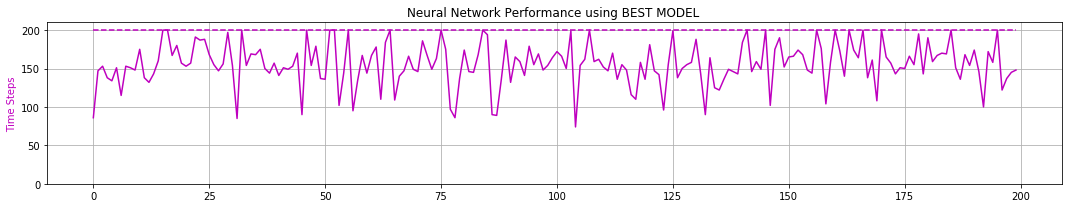

peak memory: 1484.52 MiB, increment: 1060.54 MiB
0 -max- [ 0.570  1.325  0.208  1.152]
0 -min- [-2.400 -2.935 -0.204 -1.076]

1 -max- [ 0.570  1.290  0.209  1.383]
1 -min- [-2.399 -2.938 -0.205 -1.274]

2 -max- [ 0.565  1.328  0.209  1.395]
2 -min- [-2.400 -2.946 -0.209 -1.235]

3 -max- [ 0.560  1.334  0.206  1.355]
3 -min- [-2.400 -2.935 -0.208 -1.200]

4 -max- [ 0.553  1.336  0.209  1.299]
4 -min- [-2.400 -2.942 -0.207 -1.231]

5 -max- [ 0.580  1.494  0.209  1.600]
5 -min- [-2.398 -2.935 -0.204 -1.174]

6 -max- [ 0.572  1.334  0.208  1.225]
6 -min- [-2.400 -2.924 -0.204 -1.065]

7 -max- [ 0.573  1.331  0.209  1.529]
7 -min- [-2.398 -2.960 -0.208 -1.254]

8 -max- [ 0.636  1.564  0.209  1.486]
8 -min- [-2.400 -2.938 -0.205 -1.623]

9 -max- [ 0.546  1.309  0.208  1.374]
9 -min- [-2.400 -2.939 -0.209 -1.163]

Quantization TIME:  0.01 minutes


ITERATION # 45
TOTAL EXPERIENCE GENERATED:   93691
SMALLEST TIMESTEP: 59
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4503465
TOTAL PARALLEL T

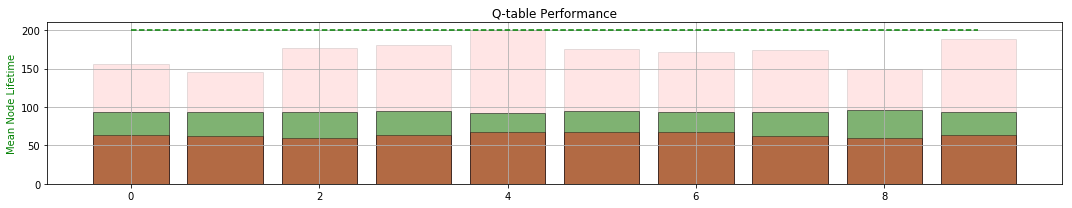

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 68.473	LOSS : 74.575	LOSS : 70.372	LOSS : 69.488	LOSS : 66.597	LOSS : 69.124	LOSS : 72.729	LOSS : 66.720	
Validating... MEAN TIME:  139.805
LOSS : 71.094	LOSS : 68.342	LOSS : 70.505	LOSS : 73.203	LOSS : 70.725	LOSS : 70.802	LOSS : 71.347	LOSS : 76.203	
Validating... MEAN TIME:  161.21
LOSS : 66.758	LOSS : 70.385	LOSS : 69.006	LOSS : 72.704	LOSS : 74.129	LOSS : 70.486	LOSS : 68.959	LOSS : 71.790	
Validating... MEAN TIME:  170.71
LOSS : 66.725	LOSS : 68.441	LOSS : 69.493	LOSS : 69.187	LOSS : 67.760	LOSS : 74.747	LOSS : 69.229	LOSS : 67.147	
Validating... MEAN TIME:  175.25
LOSS : 71.116	LOSS : 71.264	LOSS : 76.104	LOSS : 70.435	LOSS : 75.137	LOSS : 70.100	LOSS : 71.331	LOSS : 72.065	
Validating... MEAN TIME:  175.865
TRAINING TIME:0:01:11.964576


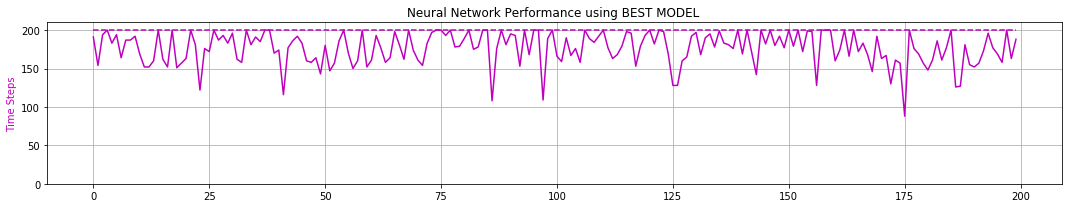

peak memory: 1475.14 MiB, increment: 992.49 MiB
0 -max- [ 0.575  1.479  0.209  1.068]
0 -min- [-1.548 -1.874 -0.207 -1.075]

1 -max- [ 0.584  1.473  0.209  1.244]
1 -min- [-1.863 -2.354 -0.209 -1.337]

2 -max- [ 0.647  1.658  0.209  1.379]
2 -min- [-1.522 -2.061 -0.208 -0.910]

3 -max- [ 0.639  1.502  0.209  1.136]
3 -min- [-1.499 -2.050 -0.207 -1.117]

4 -max- [ 0.574  1.453  0.209  1.216]
4 -min- [-1.487 -1.856 -0.209 -1.018]

5 -max- [ 0.570  1.503  0.209  1.093]
5 -min- [-1.539 -2.035 -0.208 -0.901]

6 -max- [ 0.571  1.500  0.209  1.361]
6 -min- [-1.536 -2.054 -0.208 -1.008]

7 -max- [ 0.610  1.504  0.209  1.384]
7 -min- [-1.511 -1.869 -0.209 -0.913]

8 -max- [ 0.639  1.506  0.209  1.082]
8 -min- [-1.575 -2.062 -0.207 -1.095]

9 -max- [ 0.600  1.492  0.209  1.079]
9 -min- [-2.130 -2.385 -0.209 -0.892]

Quantization TIME:  0.01 minutes


ITERATION # 46
TOTAL EXPERIENCE GENERATED:   163229
SMALLEST TIMESTEP: 80
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4666694
TOTAL PARALLEL T

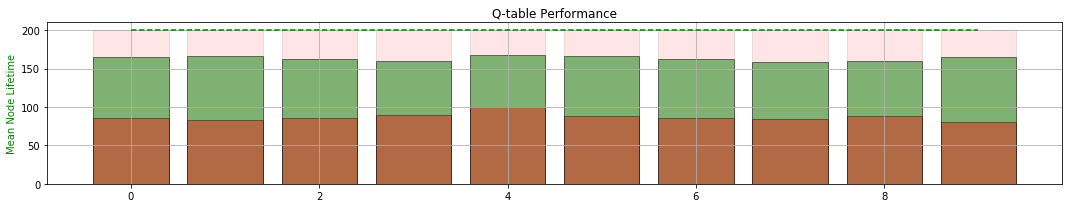

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 57.727	LOSS : 60.010	LOSS : 64.938	LOSS : 56.248	LOSS : 62.162	LOSS : 60.893	LOSS : 63.842	LOSS : 67.470	
Validating... MEAN TIME:  106.165
LOSS : 59.666	LOSS : 58.005	LOSS : 63.761	LOSS : 63.425	LOSS : 64.600	LOSS : 61.096	LOSS : 62.756	LOSS : 62.571	
Validating... MEAN TIME:  92.125
LOSS : 57.400	LOSS : 58.480	LOSS : 67.054	LOSS : 60.451	LOSS : 61.198	LOSS : 63.293	LOSS : 66.568	LOSS : 65.065	
Validating... MEAN TIME:  91.965
LOSS : 59.681	LOSS : 68.725	LOSS : 69.163	LOSS : 59.523	LOSS : 63.581	LOSS : 64.563	LOSS : 62.732	LOSS : 61.717	
Validating... MEAN TIME:  88.78
LOSS : 63.004	LOSS : 66.543	LOSS : 64.873	LOSS : 61.811	LOSS : 61.426	LOSS : 61.248	LOSS : 61.432	LOSS : 61.644	
Validating... MEAN TIME:  95.655
TRAINING TIME:0:01:01.600346


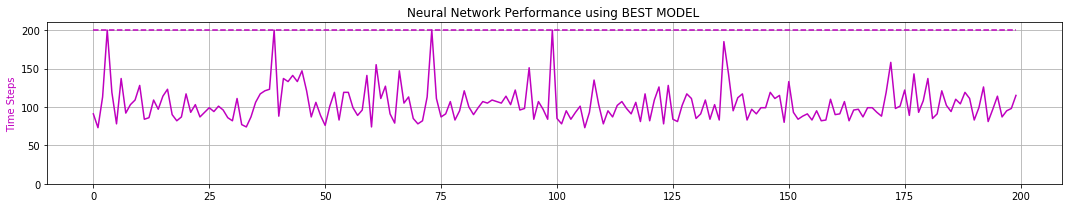

peak memory: 1506.08 MiB, increment: 1053.37 MiB
0 -max- [ 0.728  1.317  0.209  0.833]
0 -min- [-2.373 -2.592 -0.209 -1.134]

1 -max- [ 0.730  1.322  0.209  0.830]
1 -min- [-2.379 -2.712 -0.209 -1.034]

2 -max- [ 0.759  1.525  0.209  0.842]
2 -min- [-2.389 -2.704 -0.209 -1.061]

3 -max- [ 0.730  1.319  0.209  1.049]
3 -min- [-2.396 -2.617 -0.209 -1.091]

4 -max- [ 0.769  1.323  0.209  0.838]
4 -min- [-2.382 -2.723 -0.209 -0.970]

5 -max- [ 0.731  1.425  0.209  1.027]
5 -min- [-2.276 -2.721 -0.209 -1.101]

6 -max- [ 0.746  1.326  0.209  0.858]
6 -min- [-2.382 -2.608 -0.209 -1.074]

7 -max- [ 0.760  1.334  0.209  0.815]
7 -min- [-2.370 -2.720 -0.209 -1.084]

8 -max- [ 0.747  1.319  0.209  1.042]
8 -min- [-2.354 -2.598 -0.209 -1.093]

9 -max- [ 0.759  1.327  0.209  0.841]
9 -min- [-2.390 -2.615 -0.209 -0.895]

Quantization TIME:  0.01 minutes


ITERATION # 47
TOTAL EXPERIENCE GENERATED:   99493
SMALLEST TIMESTEP: 64
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4766187
TOTAL PARALLEL T

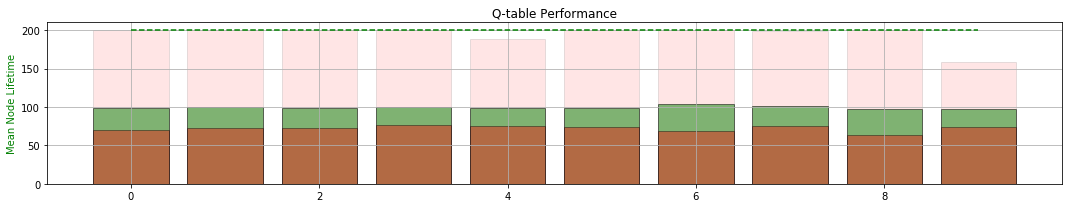

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0001
LOSS : 72.782	LOSS : 68.271	LOSS : 80.803	LOSS : 70.072	LOSS : 74.741	LOSS : 68.508	LOSS : 71.613	LOSS : 73.940	
Validating... MEAN TIME:  162.065
LOSS : 79.526	LOSS : 69.346	LOSS : 77.691	LOSS : 75.618	LOSS : 77.130	LOSS : 76.668	LOSS : 75.277	LOSS : 70.048	
Validating... MEAN TIME:  177.53
LOSS : 69.228	LOSS : 70.205	LOSS : 72.351	LOSS : 71.101	LOSS : 72.078	LOSS : 71.027	LOSS : 70.283	LOSS : 74.509	
Validating... MEAN TIME:  138.295
LOSS : 74.323	LOSS : 72.171	LOSS : 74.134	LOSS : 74.199	LOSS : 75.256	LOSS : 72.589	LOSS : 70.657	LOSS : 75.251	
Validating... MEAN TIME:  131.825
LOSS : 74.872	LOSS : 73.164	LOSS : 73.718	LOSS : 74.541	LOSS : 73.938	LOSS : 81.777	LOSS : 77.792	LOSS : 75.055	
Validating... MEAN TIME:  134.24
TRAINING TIME:0:01:11.227776


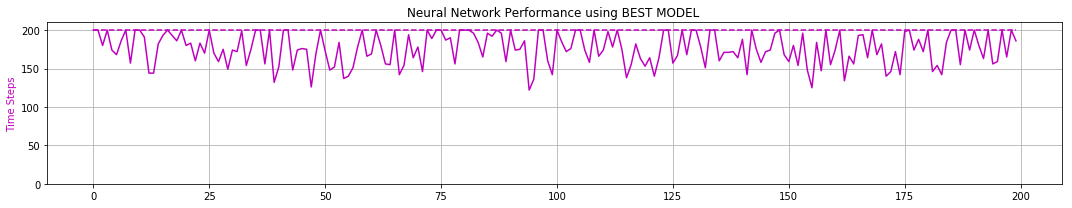

peak memory: 1437.27 MiB, increment: 1036.65 MiB
0 -max- [ 0.760  1.474  0.209  1.181]
0 -min- [-0.114 -0.825 -0.050 -0.878]

1 -max- [ 0.732  1.644  0.209  1.348]
1 -min- [-0.213 -0.811 -0.050 -0.867]

2 -max- [ 0.713  1.471  0.209  1.219]
2 -min- [-0.188 -0.812 -0.050 -0.850]

3 -max- [ 0.751  1.652  0.209  1.112]
3 -min- [-0.168 -0.626 -0.048 -1.172]

4 -max- [ 0.727  1.602  0.209  1.264]
4 -min- [-0.117 -0.825 -0.050 -0.959]

5 -max- [ 0.762  1.519  0.209  1.096]
5 -min- [-0.526 -0.730 -0.060 -0.740]

6 -max- [ 0.726  1.508  0.209  1.117]
6 -min- [-0.137 -0.814 -0.049 -0.850]

7 -max- [ 0.758  1.635  0.209  1.062]
7 -min- [-0.108 -0.633 -0.050 -0.866]

8 -max- [ 0.703  1.502  0.209  1.097]
8 -min- [-0.171 -0.788 -0.048 -0.720]

9 -max- [ 0.705  1.488  0.209  1.180]
9 -min- [-0.082 -0.764 -0.053 -0.975]

Quantization TIME:  0.01 minutes


ITERATION # 48
TOTAL EXPERIENCE GENERATED:   198858
SMALLEST TIMESTEP: 144
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   4965045
TOTAL PARALLEL

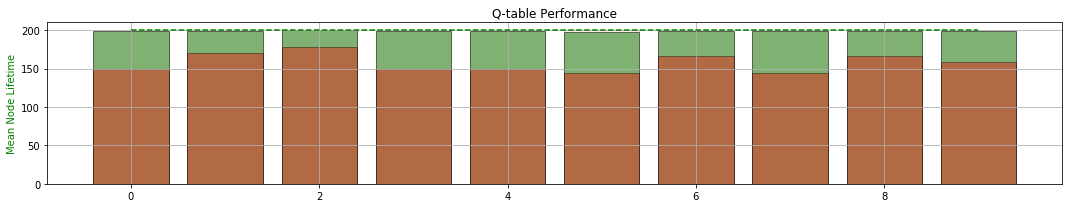

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  6691.0
Total Serial Timesteps   :  4965045.0
Speed-up                 :  742.05


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 144  48    6691    4965045     742.05
